__Corresponding Teacher__: Dawood AL CHANTI, MCF, PHELMA.

__Email__: dawood.al-chanti@grenoble-inp.fr


<center><b><font style="color: orange" size="5">BE: 3 & 4: Feature Detection and Description</font></b></center>
&ensp;

> <left><b><font style="color: blue" size="5"> Deadline: </font></b></center> &ensp;  <left><b><font style="color: red" size="5"> **24/03/2025 latest at 23h59**</font></b></center> &ensp;

 

> <left><b><font style="color: blue" size="3"> Student Information: </font></b></center> &ensp;


* Student 1:
    - Last Name: DUPAYAGE
    - First Name: Quentin
    - Identifier/algan: dupayagq
    
* Student 2:
    - Last Name: MELKIOR
    - First Name: Clément
    - Identifier/algan: melkiorc

> <left><b><font style="color: blue" size="3"> Working in pairs or alone. </font></b></center> &ensp;


* **To upload your work, follow the following steps:**
    - Go to https://chamilo.grenoble-inp.fr/ 
    - Go to the course `4PMSTIA5 Traitement d'images avancé`
        - Go to the section Travaux d'étudiants
        - Upload your work under `BE: séance 2`
        - **You must upload this `.ipynb` as it is, which will contain your code and your comments/analysis.**
            - **Any other formate, will not be corrected.**
            
            

> <left><b><font style="color: red" size="3">Important: </font></b></center> &ensp; <center><b><font style="color: red" size="3"> 
    
- **Consider delievering a clean notebook, that contain the meaningful experimental results and analysis. Remove other experiments that you performed, which you considered as just trial.**
 


--------------
> <left><b><font style="color: green" size="6"> PLEASE READ ALL INSTRUCTIONS CAREFULLY.</font></b></center> &ensp; 
----------

### Libraries: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread

from scipy.ndimage import maximum_filter
from scipy.ndimage import convolve


# Feature Matching libraries
from scipy.ndimage import map_coordinates
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform

### Provided Functions to define Gaussian function and compute its 1st order derivatives and 2nd order

In [2]:
def Gaussian_2D(sigma, N=None):
    """
    Compute a 2D Gaussian filter kernel and its first-order derivatives.
    Parameters:g,gx,gy = Gaussian_2D(sigma=1.0)
    - sigma (float): Standard deviation of the Gaussian distribution.
    - N (int, optional): Radius (half-size) of the filter. If None, uses ceil(3*sigma).
    Returns:
    - G  (ndarray): 2D Gaussian kernel of size (2*radius+1) x (2*radius+1).
    - Gx (ndarray): Partial derivative of G w.r.t. x (horizontal direction).
    - Gy (ndarray): Partial derivative of G w.r.t. y (vertical direction).
    """
   
    radius = int(np.ceil(3 * sigma)) if N is None else N
    x = np.arange(-radius, radius + 1, dtype=np.float64) 
    exponent = -0.5 * (x / sigma)**2   
    gauss_1d = np.exp(exponent)
    G = np.outer(gauss_1d, gauss_1d)

    sum_G = G.sum()
    if sum_G != 0:
        G /= sum_G
    
    X, Y = np.meshgrid(x, x)
    Gx = -(X / (sigma**2)) * G
    Gy = -(Y / (sigma**2)) * G
    return G, Gx, Gy

# Feature Matching Functions

In [3]:

def parabolic_interpolation(v):
    """Parabolic interpolation for subpixel accuracy."""
    a, b, c = 0.5 * v[0] - v[1] + 0.5 * v[2], -0.5 * v[0] + 0.5 * v[2], v[1]
    loc = -b / (2 * a) if a != 0 else 0  # Avoid division by zero
    return np.dot([a, b, c], [loc**2, loc, 1]), loc

def extract_keypoints(R, cornerImgThresholded):
    """Extracts and refines keypoints using parabolic interpolation."""
    y, x = np.nonzero(cornerImgThresholded)
    valid_mask = (x >= 2) & (x < R.shape[1] - 2) & (y >= 2) & (y < R.shape[0] - 2)
    x, y = x[valid_mask].astype(float), y[valid_mask].astype(float)

    for i in range(len(x)):
        _, dx = parabolic_interpolation(R[int(y[i]), int(x[i])-1:int(x[i])+2])
        _, dy = parabolic_interpolation(R[int(y[i])-1:int(y[i])+2, int(x[i])])
        x[i] += dx
        y[i] += dy
    return x, y

def extract_patches(I, x, y, patch_size=15):
    """Extracts 15x15 patches around keypoints using bilinear interpolation."""
    k = (patch_size - 1) / 2
    xv, yv = np.meshgrid(np.arange(-k, k+1), np.arange(-k, k+1))
    return np.stack([map_coordinates(I, (yv + yi, xv + xi)) for xi, yi in zip(x, y)], axis=-1)

def compute_ssd(patches1, patches2):
    """Computes SSD (Sum of Squared Differences) distance matrix efficiently."""
    return np.sum((patches1[..., None] - patches2[:, :, None, :]) ** 2, axis=(0, 1))

def mutual_nearest_neighbors(distmat):
    """Finds mutually nearest neighbors based on SSD."""
    ids1, ids2 = np.argmin(distmat, axis=1), np.argmin(distmat, axis=0)
    mask = np.arange(len(ids1)) == ids2[ids1]
    return np.array([[i, ids1[i], distmat[i, ids1[i]]]
                     for i in range(len(ids1)) if mask[i]])

def feature_matching(I1, R1, corners1, I2, R2, corners2, Nvis=40):
    """Performs feature matching using SSD and RANSAC-based geometric transformation estimation."""
    x1, y1 = extract_keypoints(R1, corners1)
    x2, y2 = extract_keypoints(R2, corners2)

    patches1 = extract_patches(I1, x1, y1)
    patches2 = extract_patches(I2, x2, y2)
    
    distmat = compute_ssd(patches1, patches2)
    pairs = mutual_nearest_neighbors(distmat)

    if pairs.size == 0:
        print("No matches found!")
        return None

    # Sort by SSD
    pairs = pairs[pairs[:, 2].argsort()]
    src, dst = np.array([[x1[int(p[0])], y1[int(p[0])]] for p in pairs]), \
               np.array([[x2[int(p[1])], y2[int(p[1])]] for p in pairs])

    # Estimate transformation using RANSAC
    model, _ = ransac((src, dst), ProjectiveTransform, min_samples=4, residual_threshold=2, max_trials=1000)
    H1to2p = model.params

    # Visualization
    montage = np.concatenate((I1, I2), axis=1)
    plt.figure(figsize=(16, 8))
    plt.imshow(montage, cmap='gray')
    plt.title("Top Matches using SSD", fontsize=20)

    for i in range(min(len(pairs), Nvis)):
        plt.plot(x1[int(pairs[i, 0])], y1[int(pairs[i, 0])], 'rx')
        plt.plot(x2[int(pairs[i, 1])] + I1.shape[1], y2[int(pairs[i, 1])], 'rx')
        plt.plot([x1[int(pairs[i, 0])], x2[int(pairs[i, 1])] + I1.shape[1]],
                 [y1[int(pairs[i, 0])], y2[int(pairs[i, 1])]], 'y-')

    return H1to2p

# Problem 1: Harris Corner Detection

### Task 1: Image Loading  and Visualization

**TODO:** Load and display the images `scene1.png` and `scene2.png` as gray level and normalize them between 0 and 1.

In [4]:
# Load images
image_1 = imread('scene1.png')
image_2 = imread('scene2.png')

# Normalisation 
image_1 = image_1 / 255.0
image_2 = image_2 / 255.0





**TODO:** Display the two images using subplot.

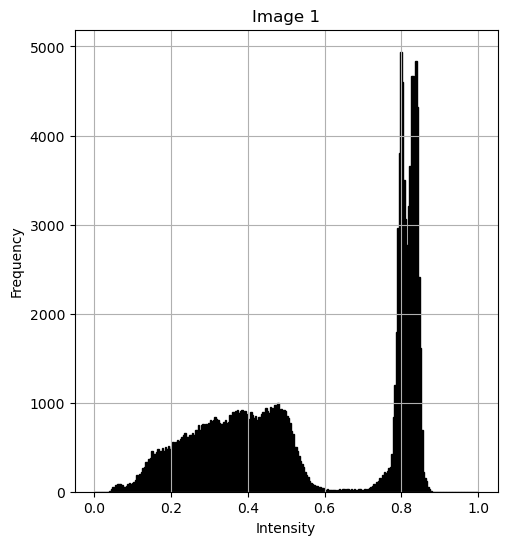

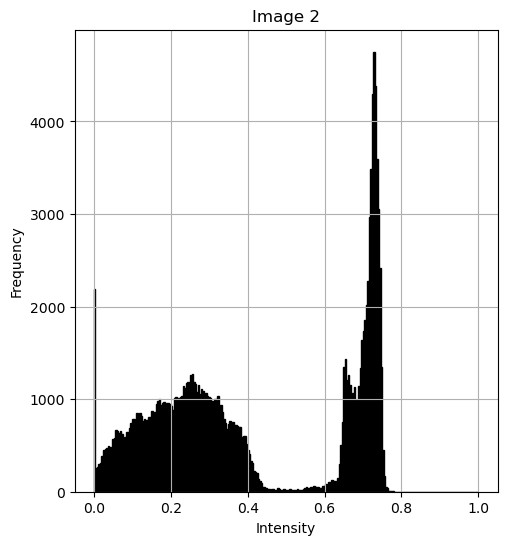

In [5]:

# Histogrammes

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(image_1.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.title("Image 1")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.grid()


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(image_2.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.title("Image 2")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.grid()


###

### Task2: Computing images partial derivatives by convolving with Gaussian derivatives to obtain. Follow the instruction below.

**TODO** Generate a gaussian filter with radius equal to 5 and sigma of 1. Display their output. Hint: you must use the function `Gaussian_2D()` provided. Store the Gaussian and its first-order derivatives in `g,gx,gy`

(-0.5, 6.5, 6.5, -0.5)

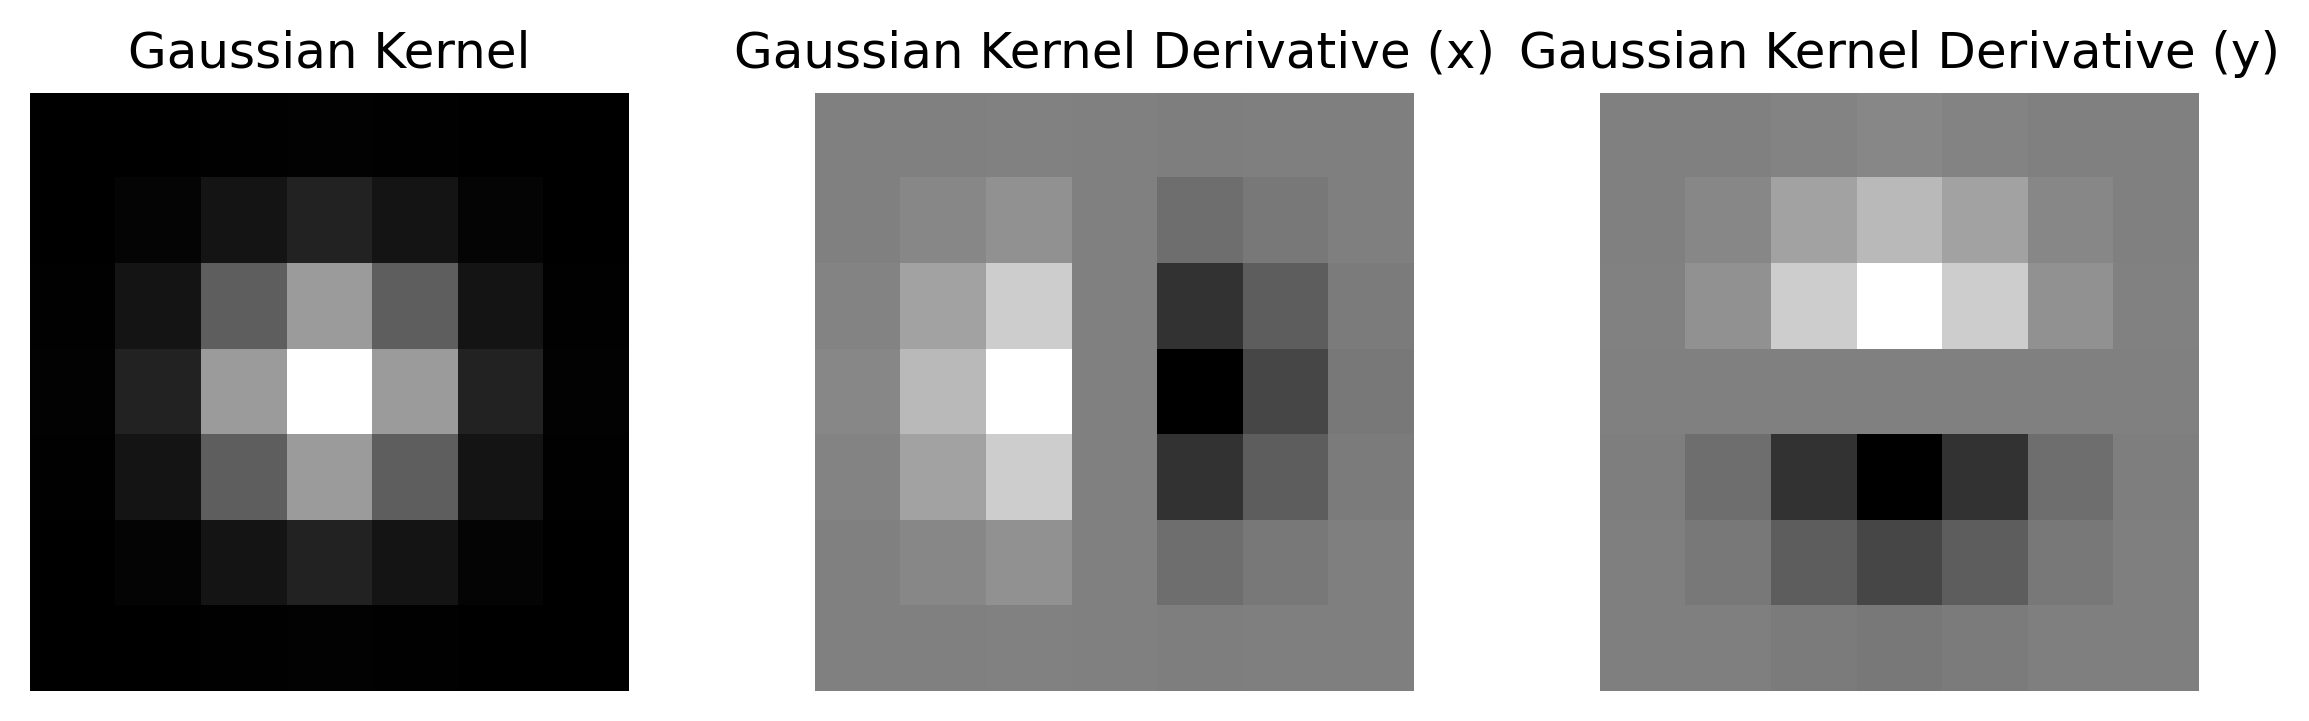

In [6]:
g,gx,gy = Gaussian_2D(sigma=1.0)

#Tracé des g gx et gy


fig, ax = plt.subplots(1, 3,figsize=(8, 8), dpi=300)
fig.tight_layout()
ax[0].imshow(g, cmap='gray')
ax[0].set_title('Gaussian Kernel')
ax[0].axis('off')
ax[1].imshow(gx, cmap='gray')
ax[1].set_title('Gaussian Kernel Derivative (x)')
ax[1].axis('off')
ax[2].imshow(gy, cmap='gray')
ax[2].set_title('Gaussian Kernel Derivative (y)')
ax[2].axis('off')
###

**TODO** Use the function `convolve()` imported up to perform convolution between the `image_1` and gx and gy in order to obtain its gradient with respect to x and y respectively. Store the results in `Ix_image_1` and `Iy_image_1`. Same for `image_2` and store the results in `Ix_image_2` and `Iy_image_2`. The function `convolve` take a parameter called mode, you can use `constant` or `reflect` which deal better with borders. Display in a subplot the gradients of each image.

In [7]:
# Convolution in order to have gradient with x/y for both image 1 and 2
Ix_image_1 = convolve(image_1,gx, mode='constant')
Iy_image_1 = convolve(image_1, gy, mode='constant')
Ix_image_2 = convolve(image_2,gx, mode='constant')
Iy_image_2 = convolve(image_2, gy, mode='constant')

# Convolution operation in order to have smoothed image for both image 1 and 2
image_1_smoothed = convolve(image_1, g)
image_2_smoothed = convolve(image_2, g)


(-0.5, 427.5, 341.5, -0.5)

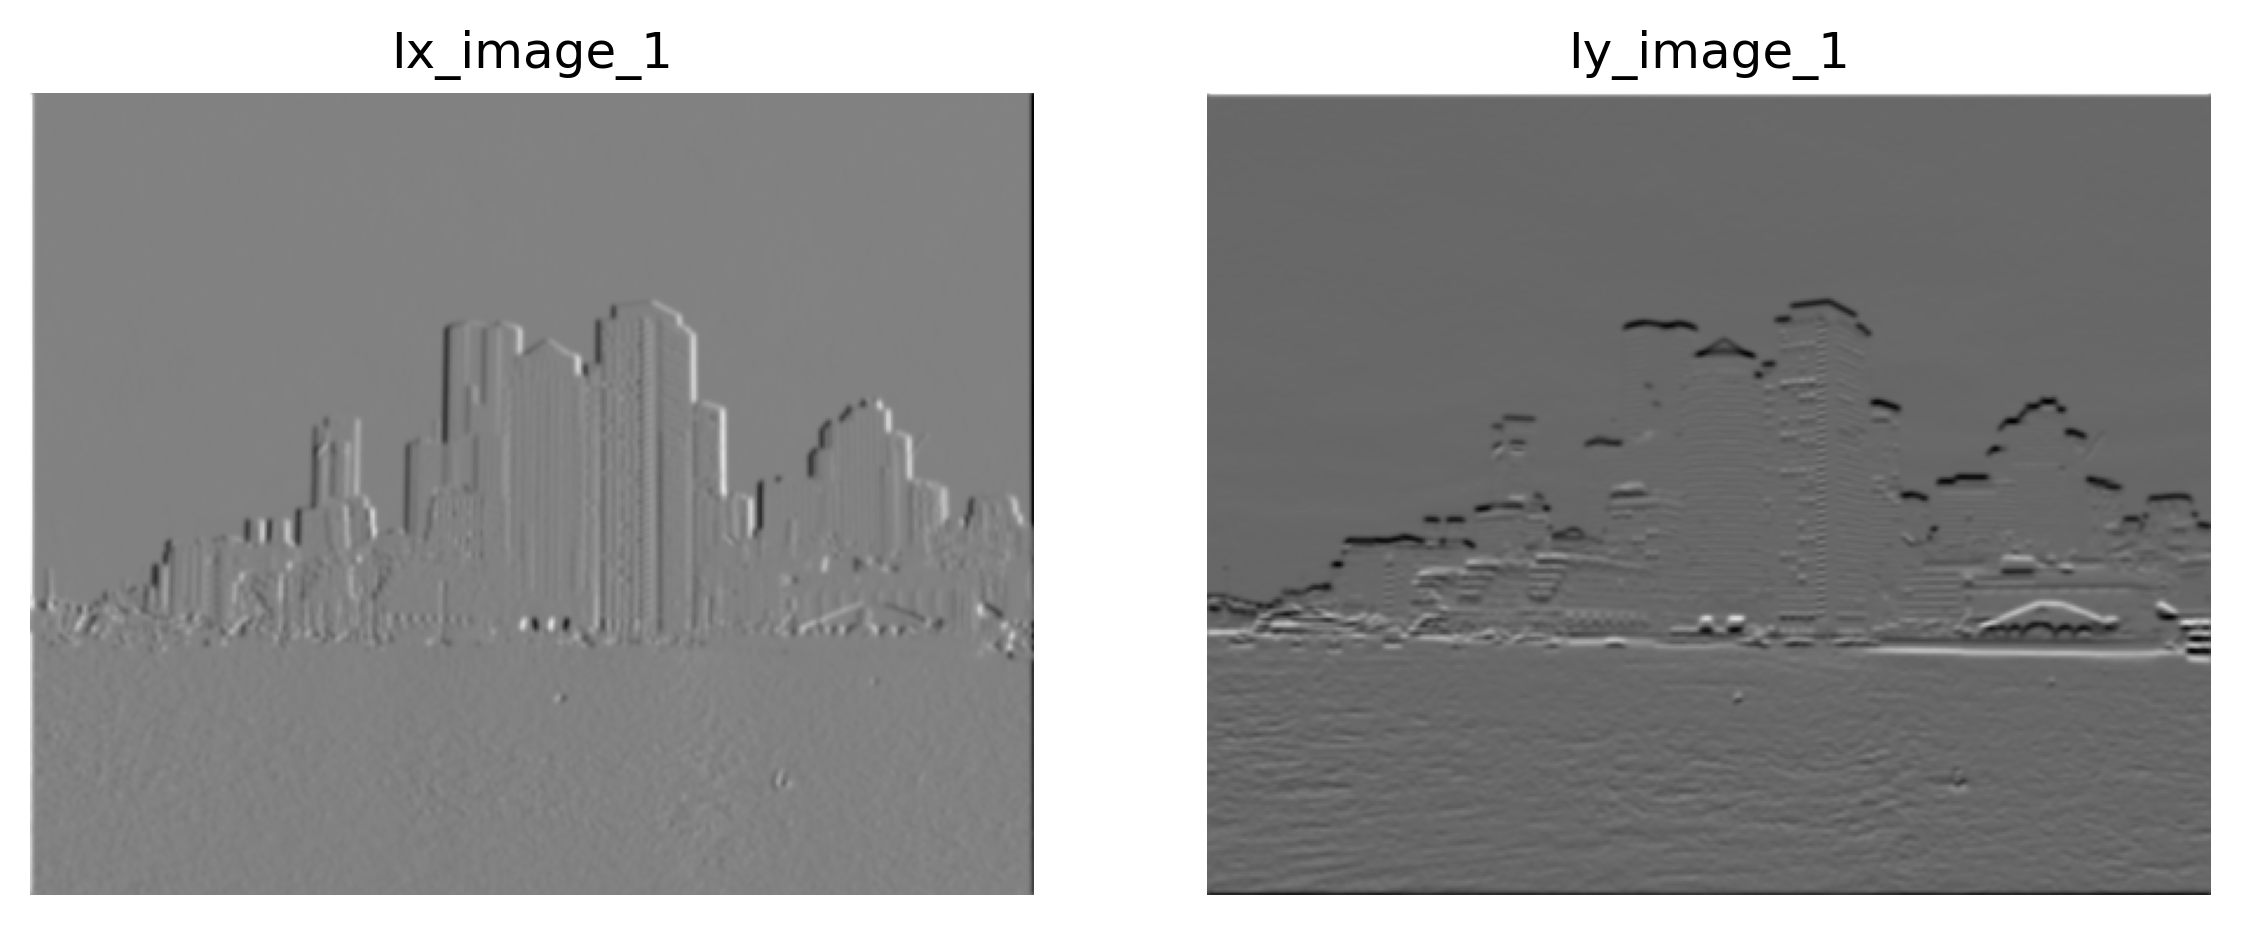

In [8]:
fig, ax = plt.subplots(1, 2,figsize=(8, 8), dpi=300)
 
fig.tight_layout()
ax[0].imshow(Ix_image_1,cmap='gray')
ax[0].set_title('Ix_image_1')
ax[0].axis('off')
ax[1].imshow(Iy_image_1, cmap='gray')
ax[1].set_title('Iy_image_1')
ax[1].axis('off')

(-0.5, 427.5, 341.5, -0.5)

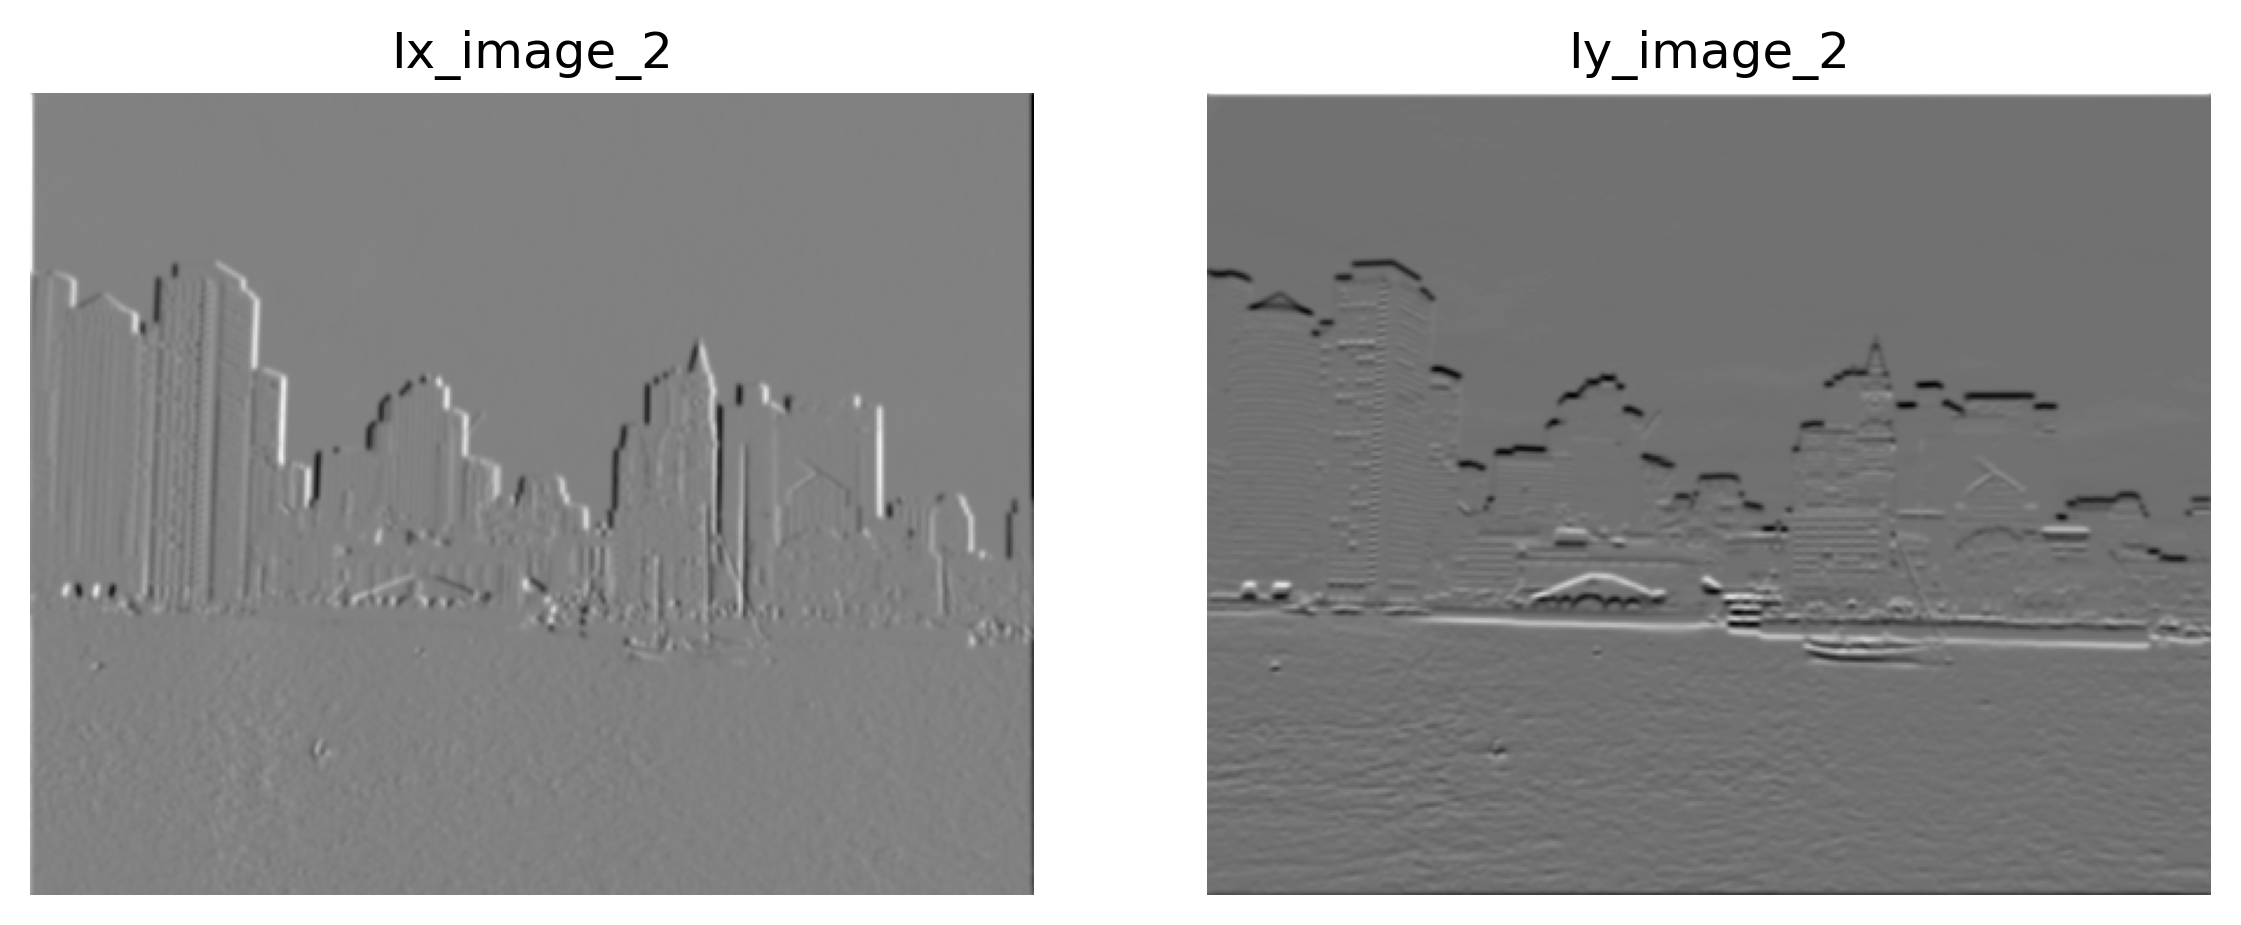

In [9]:
fig, ax = plt.subplots(1, 2,figsize=(8, 8), dpi=300)
 
fig.tight_layout()
ax[0].imshow(Ix_image_2, cmap='gray')
ax[0].set_title('Ix_image_2')
ax[0].axis('off')
ax[1].imshow(Iy_image_2, cmap='gray')
ax[1].set_title('Iy_image_2')
ax[1].axis('off')

### Task3: Computing Second Moment Matrix for each image. Follow the instruction.

The second moment matrix $M$ is defined as:

$$
M =
\begin{bmatrix}
M_{11} & M_{12} \\
M_{12} & M_{22}
\end{bmatrix}
$$

where:

- $ M_{11} = G_{\sigma} * I_x^2 $ → Smoothed squared gradient in the x-direction.
- $ M_{22} = G_{\sigma} * I_y^2 $ → Smoothed squared gradient in the y-direction.
- $ M_{12} = G_{\sigma} * I_x I_y $ → Smoothed mixed derivative. Note that $M_{21}$ = $M_{12}$.

---


**TODO** We would like to compute the second moment matrix for the images. So far we have calcualted for each image its 1st order derivatives Ix and Iy, therefor:

 1. Compute squared gradients and mixed product for each image an store them in:
     
     - For image_1:
       * Ix2_image_1 
       * Iy2_image_1
       * Ixy_image_1
    ------------
     - For image_2:
       * Ix2_image_2 
       * Iy2_image_2 
       * Ixy_image_2

------    
2. Once calculated, in practice we do Gaussian smoothing to improve robustness in detecting edges and corners. It serves as noise reduction to reduce false corners, ensures continuous and stable values, and provides a localized averaging of gradient products over a region. Therefore, over each of the outcomes in (1) apply Gaussian smoothing with `g` that you already obtained in Task2. For that again use the `convolve` function. Store the results in:

     - For image_1:
       * M11_image_1 
       * M22_image_1
       * M12_image_1
    ------------
     - For image_2:    
       * M11_image_2
       * M22_image_2
       * M12_image_2


3. Display in a subplot each of these images.

In [10]:
# Squared gradients
Ix2_image_1 = Ix_image_1**2
Iy2_image_1 = Iy_image_1**2

# Mixed product
Ixy_image_1 = Ix_image_1*Iy_image_1

In [11]:
# Convolution of squared gradients and mixed product with the gaussian
M11_image_1 = convolve(Ix2_image_1,g, mode='constant')
M22_image_1 = convolve(Iy2_image_1,g, mode='constant')
M12_image_1 = convolve(Ixy_image_1,g, mode='constant')
M21_image_1 = M12_image_1

In [12]:
# Squared gradients
Ix2_image_2 = Ix_image_2**2
Iy2_image_2 = Iy_image_2**2

# Mixed product
Ixy_image_2 = Ix_image_2 * Iy_image_2


In [13]:
# Convolution of squared gradients and mixed product with the gaussian
M11_image_2 = convolve( Ix2_image_2,g, mode='constant')
M22_image_2 = convolve( Iy2_image_2,g, mode='constant')
M12_image_2 = convolve(Ixy_image_2,g, mode='constant')
M21_image_2 = M12_image_2

(-0.5, 427.5, 341.5, -0.5)

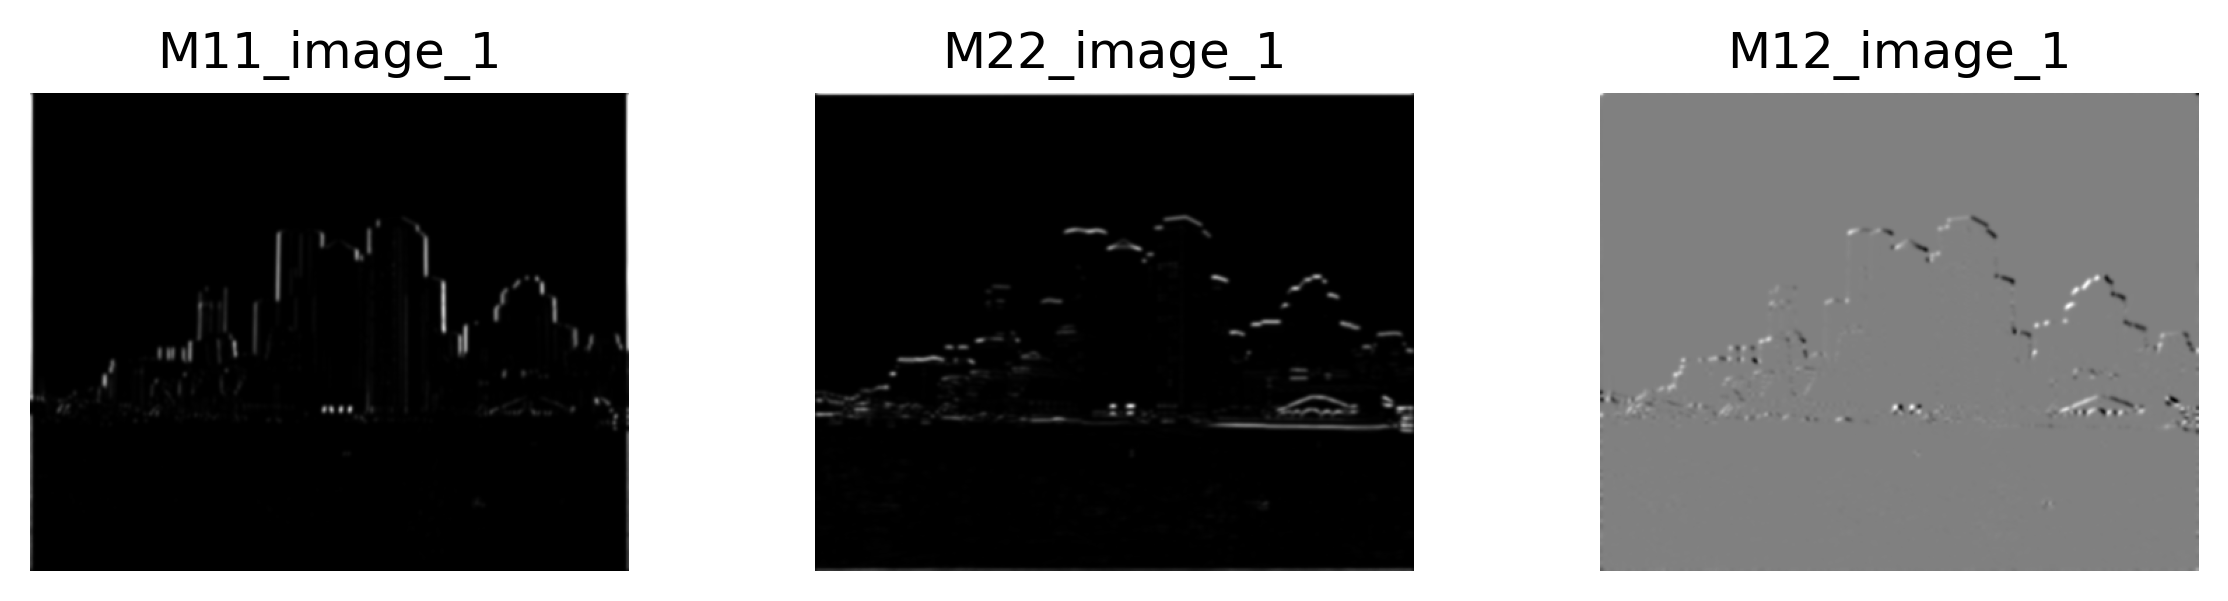

In [14]:
fig, ax = plt.subplots(1, 3,figsize=(8, 8), dpi=300)
 
fig.tight_layout()
ax[0].imshow(M11_image_1, cmap='gray')
ax[0].set_title('M11_image_1')
ax[0].axis('off')
ax[1].imshow(M22_image_1, cmap='gray')
ax[1].set_title('M22_image_1')
ax[1].axis('off')
ax[2].imshow(M12_image_1, cmap='gray')
ax[2].set_title('M12_image_1')
ax[2].axis('off')
###

(-0.5, 427.5, 341.5, -0.5)

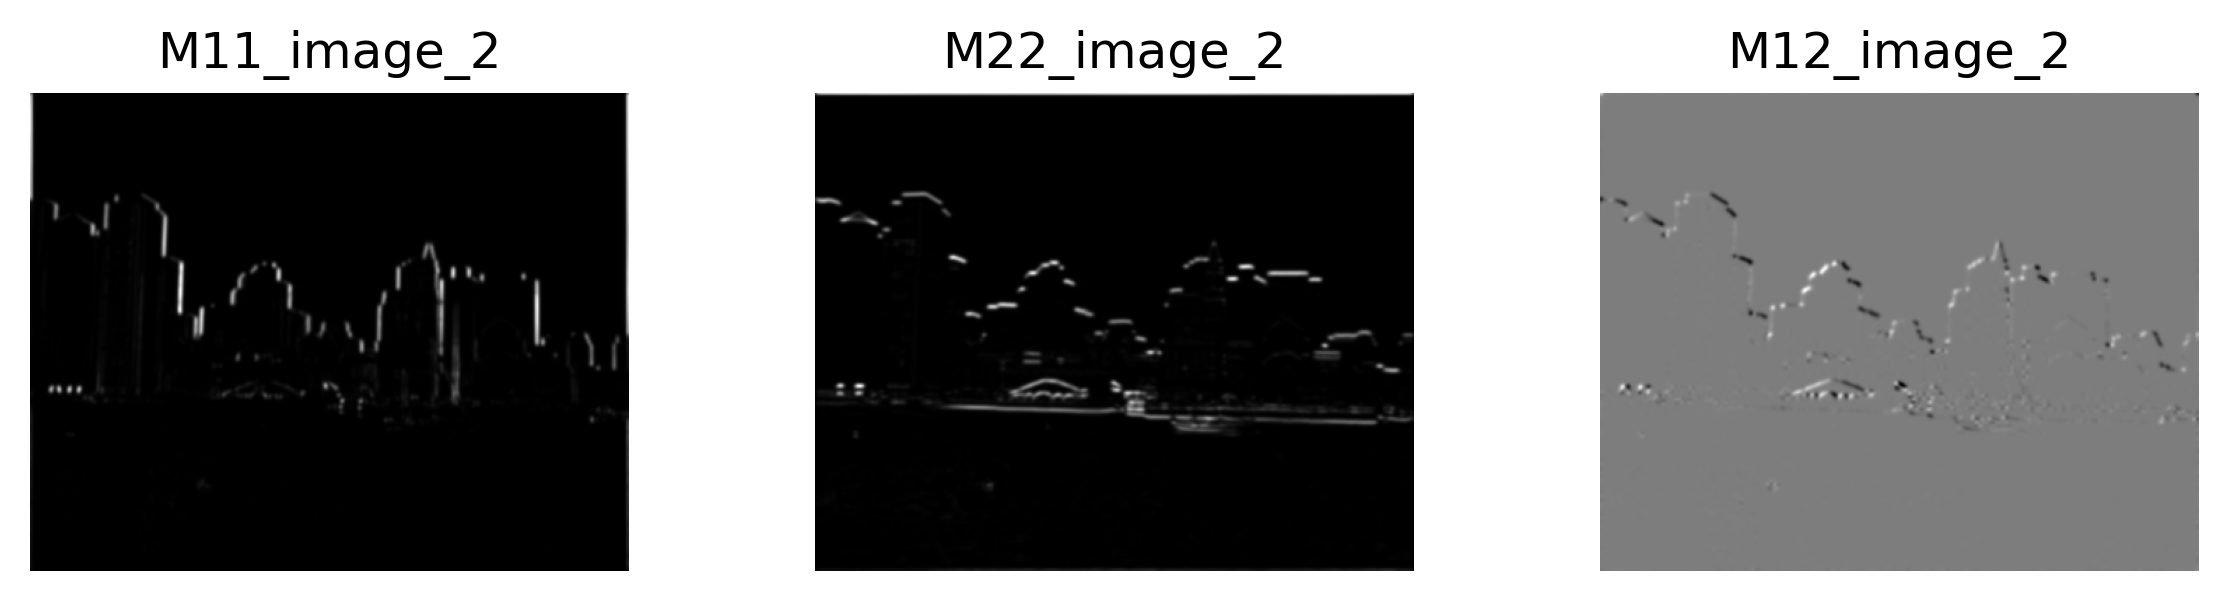

In [15]:
fig, ax = plt.subplots(1, 3,figsize=(8, 8), dpi=300)
 
fig.tight_layout()
ax[0].imshow(M11_image_2, cmap='gray')
ax[0].set_title('M11_image_2')
ax[0].axis('off')
ax[1].imshow(M22_image_2, cmap='gray')
ax[1].set_title('M22_image_2')
ax[1].axis('off')
ax[2].imshow(M12_image_2, cmap='gray')
ax[2].set_title('M12_image_2')
ax[2].axis('off')
###

### Task4: We would like to compute the eigenvalues $ \lambda_1 $ and $ \lambda_2 $ of the second moment matrix M for each image. Follow the instruction.

####  We have two different approaches, the 1st is what you have seen in the class and it is simplest one.

###### **1. Characteristic Equation Approach**
To find the eigenvalues $ \lambda_1 $ and $ \lambda_2 $, we solve the characteristic equation:

$$
\det(M - \lambda I) = 0
$$

Expanding the determinant:

$$
\begin{vmatrix}
M_{11} - \lambda & M_{12} \\
M_{12} & M_{22} - \lambda
\end{vmatrix}
= 0
$$

$$
(M_{11} - \lambda)(M_{22} - \lambda) - M_{12}^2 = 0
$$

$$
\lambda^2 - (M_{11} + M_{22})\lambda + (M_{11} M_{22} - M_{12}^2) = 0
$$

Using the **quadratic formula**, the eigenvalues are:

$$
\lambda_{1} = \frac{(M_{11} + M_{22}) + \sqrt{(M_{11} - M_{22})^2 + 4M_{12}^2}}{2}
$$
$$
\lambda_{2} = \frac{(M_{11} + M_{22}) - \sqrt{(M_{11} - M_{22})^2 + 4M_{12}^2}}{2}
$$




###### **2. Trace and Determinant Approach** : This approach is more computaitionaly effecient.

The eigenvalues of the second moment matrix can also be computed using the **trace** and **determinant** of the matrix. Where

- **Trace** of the matrix:

  $$
  \text{trace}(M) = M_{11} + M_{22}
  $$

- **Determinant** of the matrix:

  $$
  \det(M) = M_{11} M_{22} - M_{12}^2
  $$

###### Therefore, Eigenvalue Computation Using Trace and Determinant become:
The eigenvalues are given by:

  $$
  \lambda_{1} = \frac{\text{trace}(M) + \sqrt{\text{trace}(M)^2 - 4 \det(M)}}{2}
  $$
 

  $$
  \lambda_{2} = \frac{\text{trace}(M) - \sqrt{\text{trace}(M)^2 - 4 \det(M)}}{2}
  $$
 

#### TODO:
1. Use one of these two approaches to compute $ \lambda_1 $ and $ \lambda_2 $ for both images and call them `lambda_1_1` and `lambda_2_1` for the 1st image and `lambda_1_2` and `lambda_2_2` for the second image.

2. Perform Visual Analysis: 
    - In a subplot display $\lambda$s for each image.    
    - Compare brightness in the two images.
    - Identify which image has more bright points, indicating stronger features.
     - Look for differences in corner strengths across the images.
    
    - Then generate the code we gave you which will perform scatter plot of `lambda_1` vs `lambda_2` for each image. 
    -  Interpret the distribution of points to determine the dominance of corners, edges, and flat regions.
    - Assess the consistency of visual brightness (λ₁ and λ₂ intensity) with the scatter plot classification.




In [16]:
# Quadratic Equation


trace_M1 = M11_image_1 + M22_image_1
det_M1 = M11_image_1*M22_image_1 - M12_image_1**2

lambda_1_1 = (trace_M1 + np.sqrt(trace_M1**2 - 4*det_M1))/2
lambda_2_1 = (trace_M1 - np.sqrt(trace_M1**2 - 4*det_M1))/2



trace_M2 = M11_image_2 + M22_image_2
det_M2 = M11_image_2*M22_image_2 - M12_image_2**2

lambda_1_2 = (trace_M2 + np.sqrt(trace_M2**2 - 4*det_M2))/2
lambda_2_2 = (trace_M2 - np.sqrt(trace_M2**2 - 4*det_M2))/2


lambda_1_1 = lambda_1_1[3:,::]
lambda_2_1 = lambda_2_1[3:,::]
lambda_1_2 = lambda_1_2[3:,::]
lambda_2_2 = lambda_2_2[3:,::]



# 2. Perform Visual Analysis: 
#     - In a subplot display $\lambda$s for each image.    
#     - Compare brightness in the two images.
#     - Identify which image has more bright points, indicating stronger features.
#      - Look for differences in corner strengths across the images.
    
#     - Then generate the code we gave you which will perform scatter plot of `lambda_1` vs `lambda_2` for each image. 
#     -  Interpret the distribution of points to determine the dominance of corners, edges, and flat regions.
#     - Assess the consistency of visual brightness (λ₁ and λ₂ intensity) with the scatter plot classification.




 

(-0.5, 427.5, 338.5, -0.5)

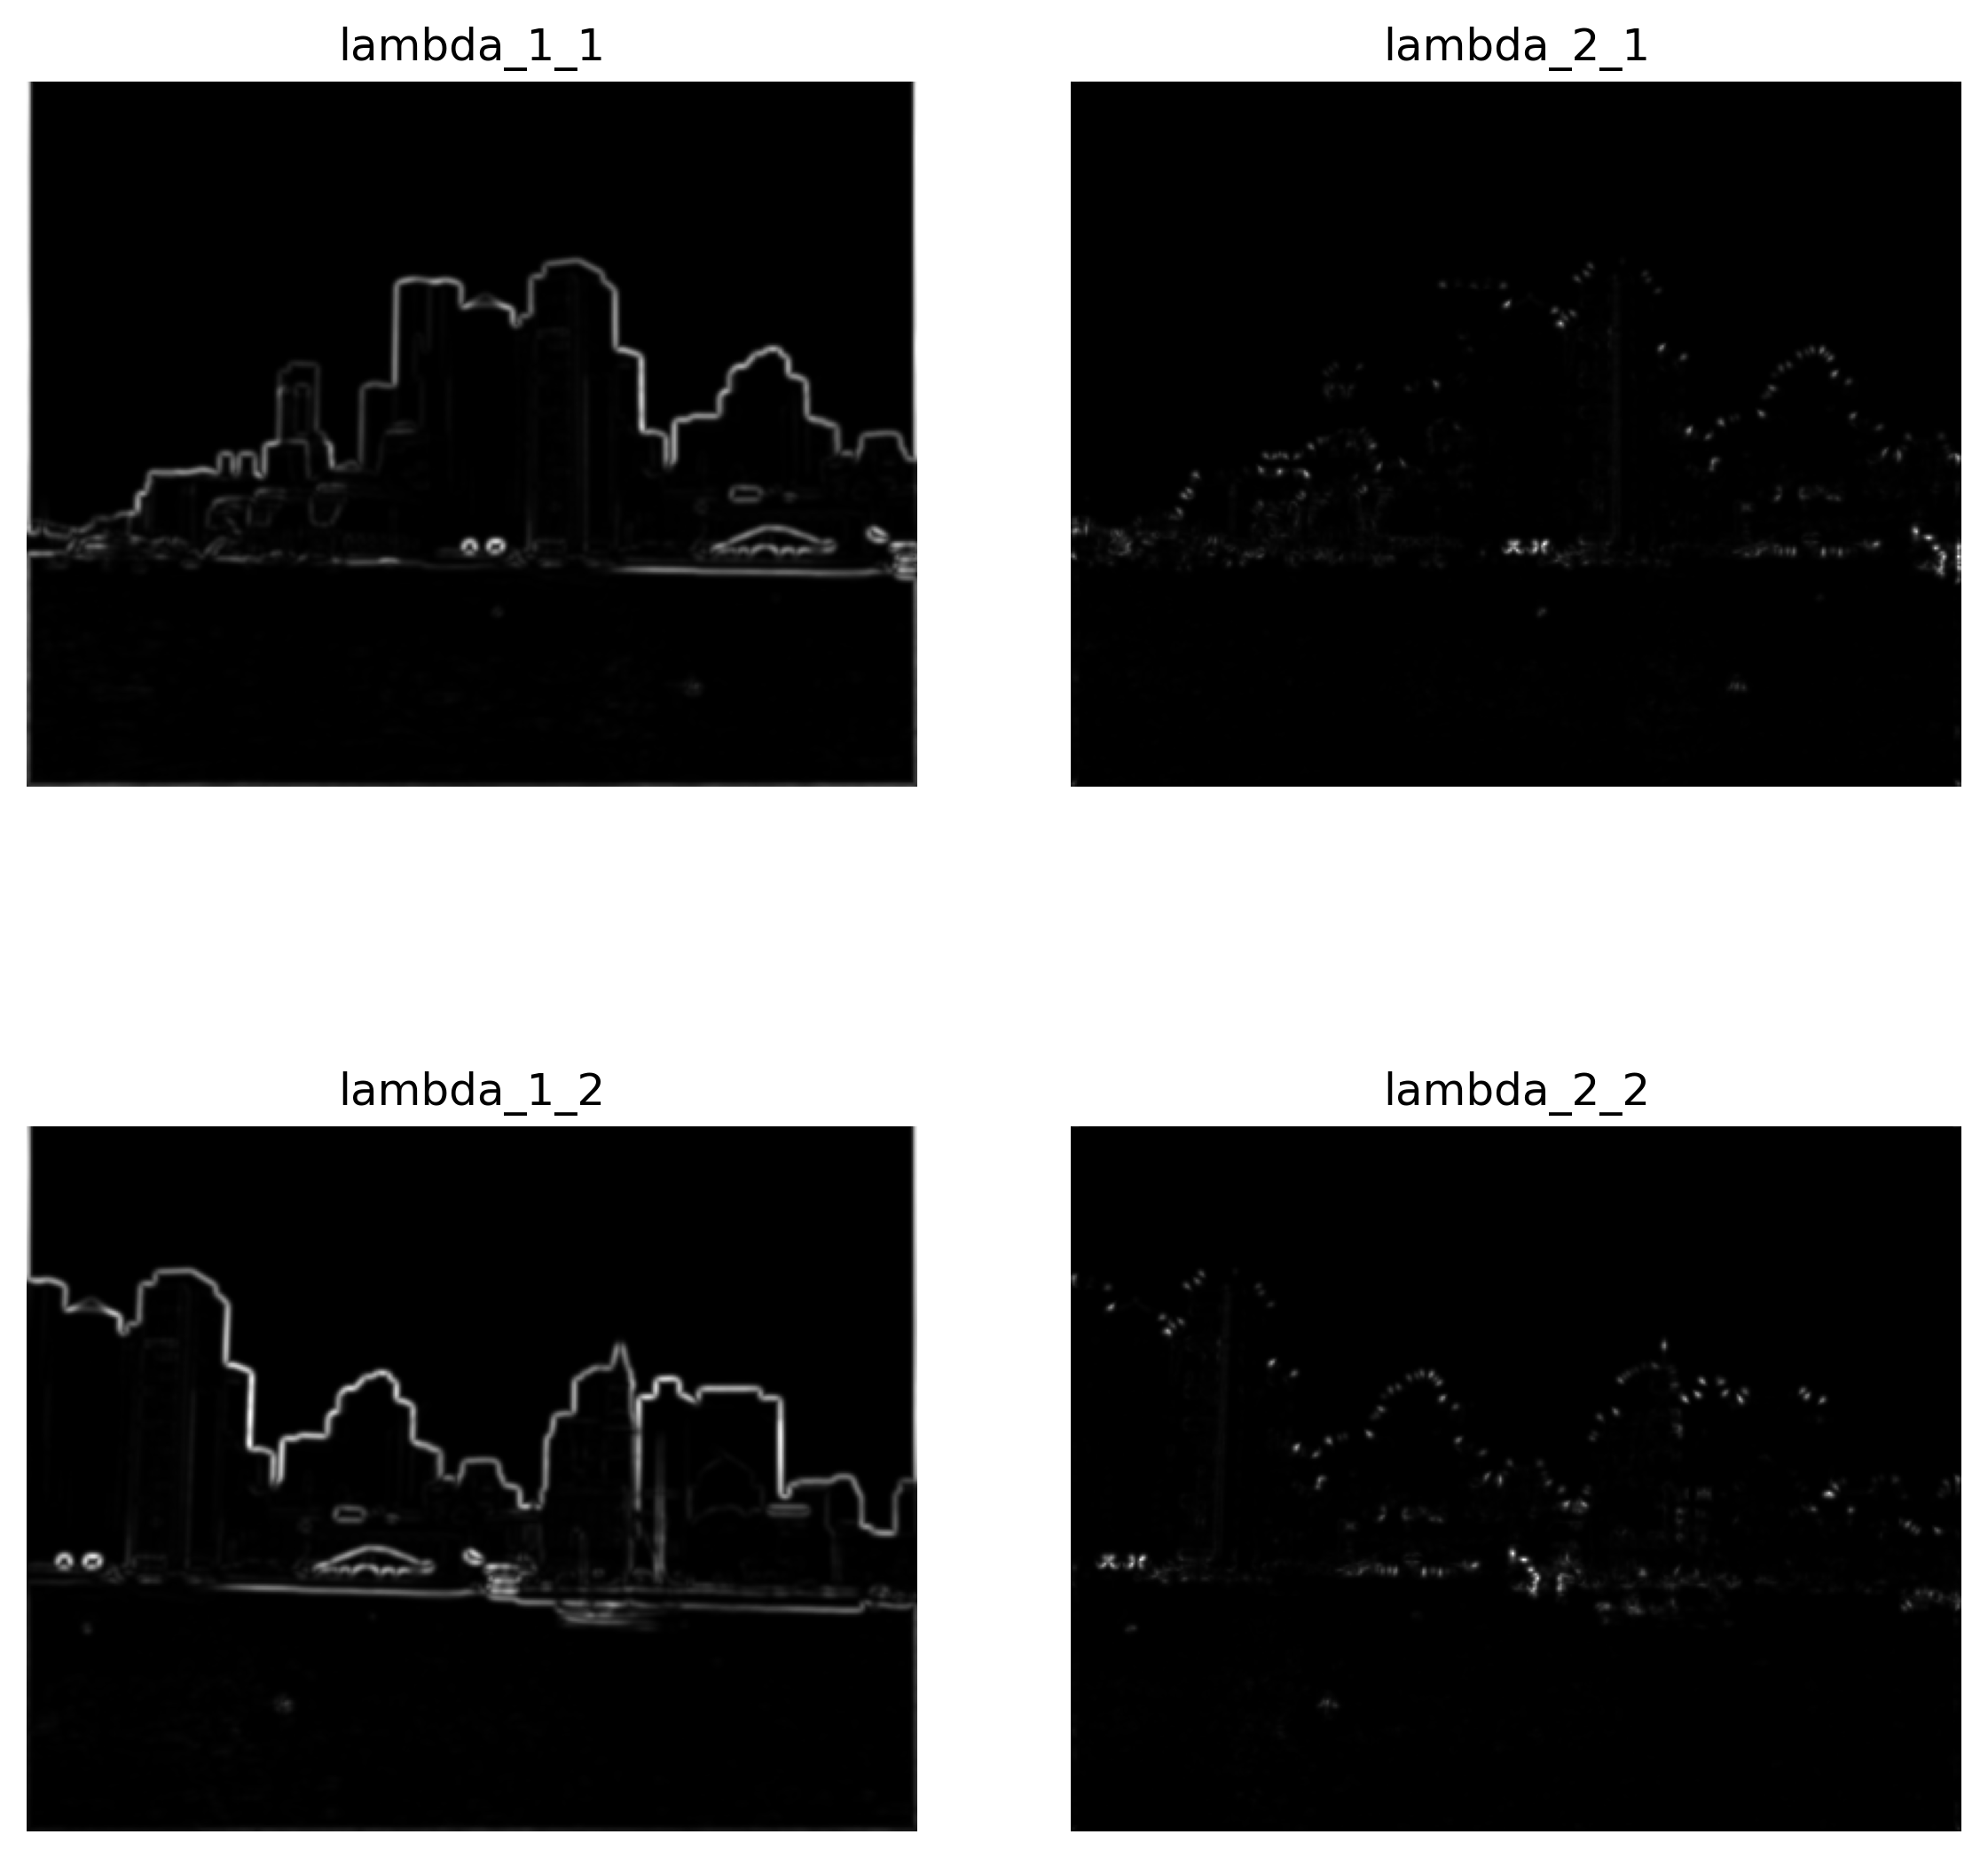

In [17]:
fig, ax = plt.subplots(2, 2,figsize=(8, 8), dpi=300)
 
fig.tight_layout()

ax[0,0].imshow(lambda_1_1, cmap='gray')
ax[0,0].set_title('lambda_1_1')
ax[0,0].axis('off')
ax[0,1].imshow(lambda_2_1, cmap='gray')
ax[0,1].set_title('lambda_2_1')
ax[0,1].axis('off')
ax[1,0].imshow(lambda_1_2, cmap='gray')
ax[1,0].set_title('lambda_1_2')
ax[1,0].axis('off')
ax[1,1].imshow(lambda_2_2, cmap='gray')
ax[1,1].set_title('lambda_2_2')
ax[1,1].axis('off')

###

#### GIVEN: Here based on your computation of $lambda$s we will perform scatter plot to have a general idea about the presence of corners, edges or flat regions.

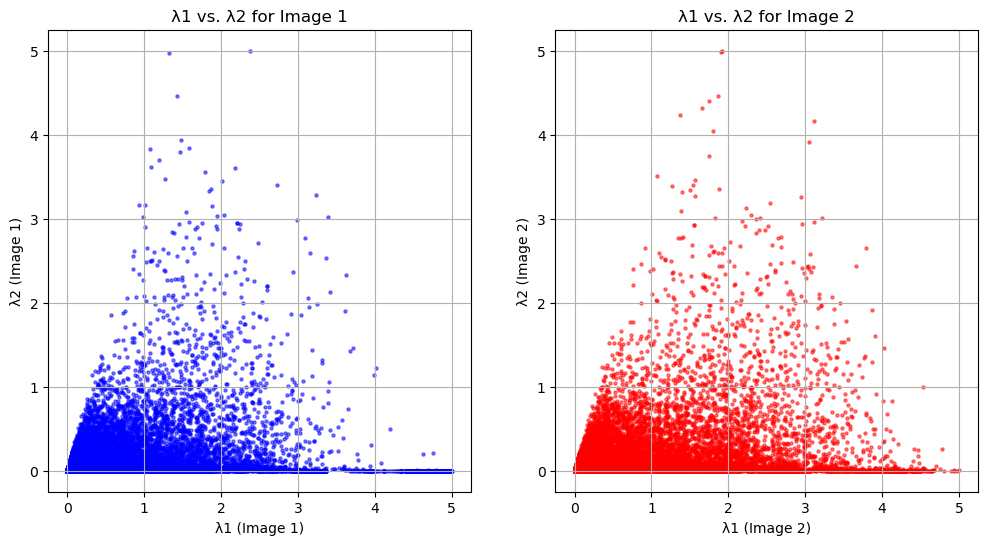

In [18]:
# Normalize the values for better visualization
def normalize_image(img):
    img = img.astype(np.float32)
    return (img - img.min()) / (img.max() - img.min()) * 5  # Scale to match λ range

lambda1_img1 = normalize_image(lambda_1_1).flatten()
lambda2_img1 = normalize_image(lambda_2_1).flatten()
lambda1_img2 = normalize_image(lambda_1_2).flatten()
lambda2_img2 = normalize_image(lambda_2_2).flatten()

# Scatter plot for both images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(lambda1_img1, lambda2_img1, color='blue', alpha=0.5, s=5)
plt.xlabel("λ1 (Image 1)")
plt.ylabel("λ2 (Image 1)")
plt.title("λ1 vs. λ2 for Image 1")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(lambda1_img2, lambda2_img2, color='red', alpha=0.5, s=5)
plt.xlabel("λ1 (Image 2)")
plt.ylabel("λ2 (Image 2)")
plt.title("λ1 vs. λ2 for Image 2")
plt.grid(True)

plt.show()


On observe que les valeurs de lambda_1 s'étale beaucoup plus sur toute la plage [0,5] que lambda_2: sachant que l'on détecte principalement les bordures (edges), il est normal que le lambda_min soit moins large, les quelques valeurs importantes de lambda_2 sont la détection des corners des batiments. De plus, on observe qu'il y a beaucoup de points dans la zone des deux lambdas faibles: d'après le cours, lorsque les deux lambdas sont petit, c'est une "flat_region", lorsque lambda_1 >> lambda_2, on détecte des bordures, et lorsque les 2 lambda sont importants, alors on détecte des coins. Sur l'image, on observe qu'il y a beaucoup de zones plates, qui sont les zones correspondants au ciel ou a la mer, les quelques valeurs où lambda_1 et lambda_2 sont supérieures à 2 et similaires en valeurs, ce sont les coins.

### Task5: Compute the Harris Corner Response FunctionFollow the instruction.

 
We would like to compute the **Harris Corner Response Function** using the eigenvalues $ \lambda_1 $ and $ \lambda_2 $ obtained from the second moment matrix $M$ for each image.

**Harris Corner Response Formula is given by:**

$$
R = \lambda_1 \lambda_2 - k (\lambda_1 + \lambda_2)^2
$$

where:
- $ \lambda_1 $ and $ \lambda_2 $ are the eigenvalues of the second moment matrix.
- $ k $ is an empirical constant, typically chosen as **0.04** to **0.06**. By default it is 0.04.


**TODO**

1. Compute $R$ for each image and store the results in $R1$ and $R2$.

2. Compute the **maximum Harris corner response value** in $R1$ and $R2$ which is the pixel that indicate the most prominent/strongest corner in each of the two images. Later on, we will use these values to threshold the response functions $R1$ and $R2$ and only keep strong corners based on a certain threshold we will define. In general, **to compute the largest value in a matrix**, we can use `np.amax(matrix)` and to get the location we can do `np.unravel_index(np.argmax(matrix), matrix.shape)`, in this way we can superimose it on the image $R1 or $R2$ and better interepret the results. Given that, **compute the maximal respond value and its location**, store the results in `maxCornerValue1, Location1` and `maxCornerValue2, Location2`.
3. Run the given code to superimpose the location of the strongest corner in each of the images and visualize it.





In [19]:
# Harris corner Response
k = 0.04
R1 = lambda_1_1 * lambda_2_1 - k * (lambda_1_1 + lambda_2_1)**2
R2 = lambda_1_2 * lambda_2_2 - k * (lambda_1_2 + lambda_2_2)**2

# #Nous avons redimmensionnés les images car les coins de l'image de base parasitaient les résultats
# R1 =R1[5:-5,5:-5]
# R2 =R2[5:-5,5:-5]
#R1 = R1[:,:]
#print(np.sort(R1.ravel()))

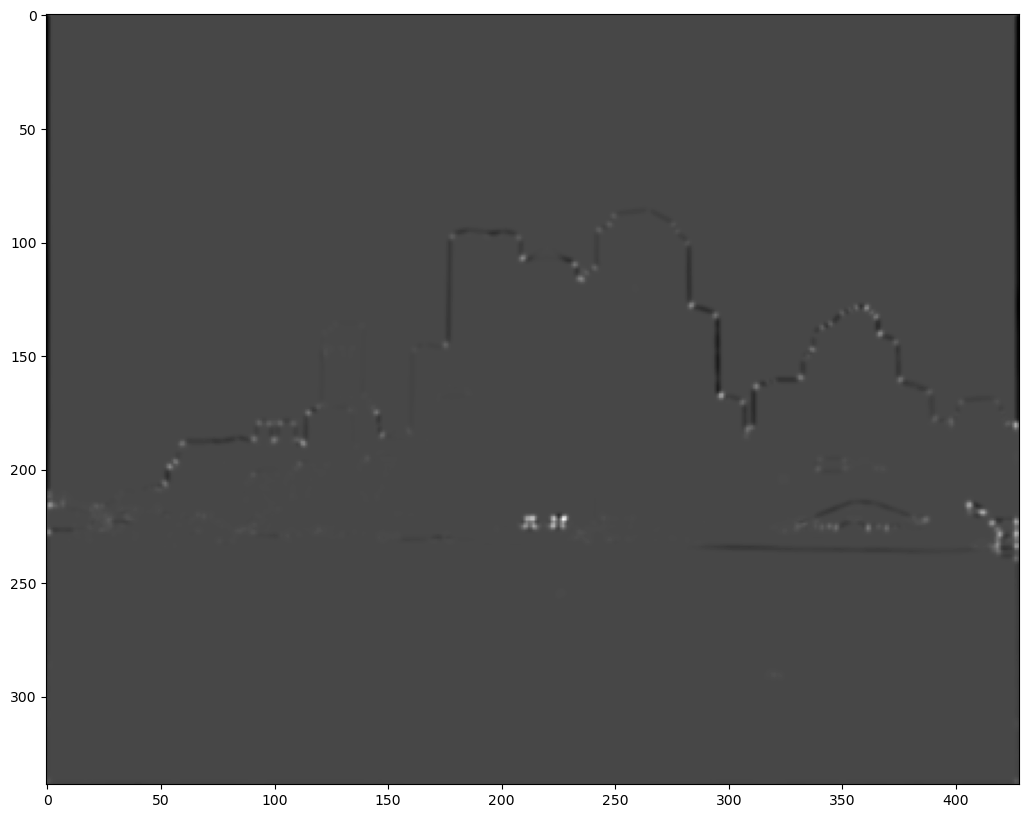

In [20]:
plt.figure(figsize=(15,10))
plt.imshow(R1, cmap='gray')

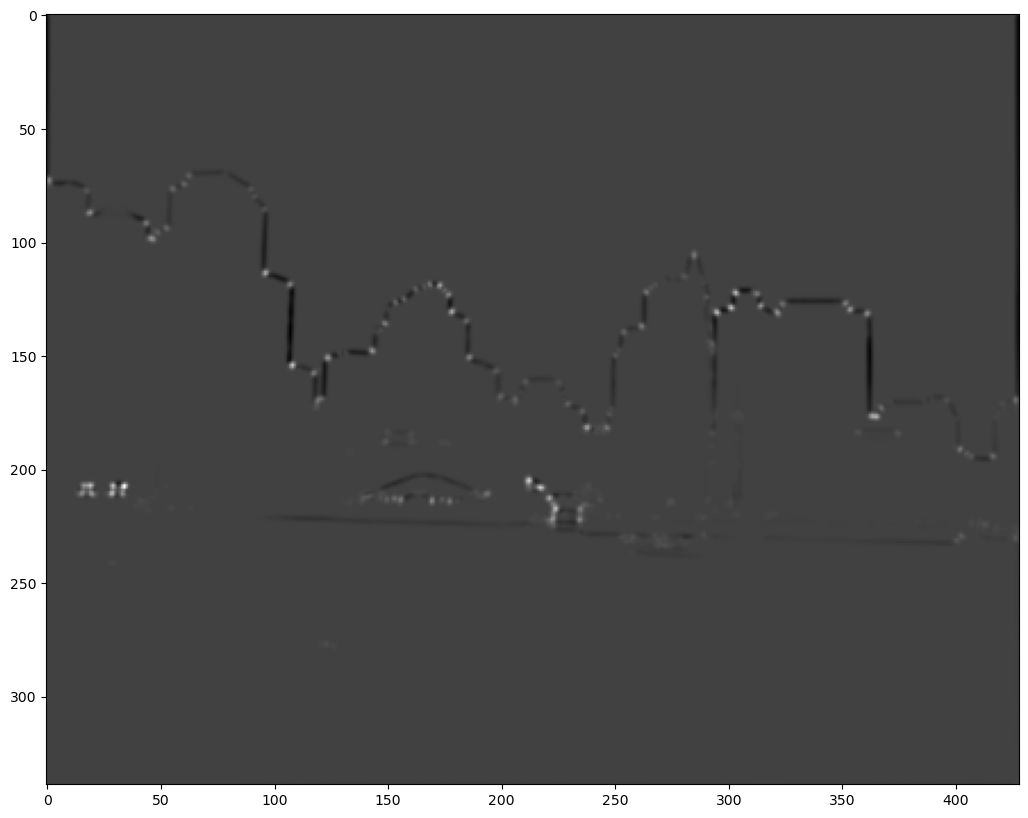

In [21]:
plt.figure(figsize=(15,10))
plt.imshow(R2, cmap='gray')

maxCornerValue1, Location1
maxCornerValue2, Location2


In [22]:
maxCornerValue1 = np.amax(R1)
maxCornerValue2 = np.amax(R2)

print("Maximum Harris Response for Image 1:", maxCornerValue1)
print("Maximum Harris Response for Image 2:", maxCornerValue2)


Maximum Harris Response for Image 1: 0.0001708604081411545
Maximum Harris Response for Image 2: 0.00012474951603032042


In [23]:
Location1 = np.unravel_index(np.argmax(R1), R1.shape)
Location2 = np.unravel_index(np.argmax(R2), R2.shape)
print("Maximum Harris Response for Image 1 pixel position:", Location1)
print("Maximum Harris Response for Image 2 pixel position:", Location2)

Maximum Harris Response for Image 1 pixel position: (222, 227)
Maximum Harris Response for Image 2 pixel position: (207, 34)


In [24]:
#Redimensionnement des images
image_1_resized = image_1[3:,::]
image_2_resized = image_2[3:,::]

(-0.5, 427.5, 338.5, -0.5)

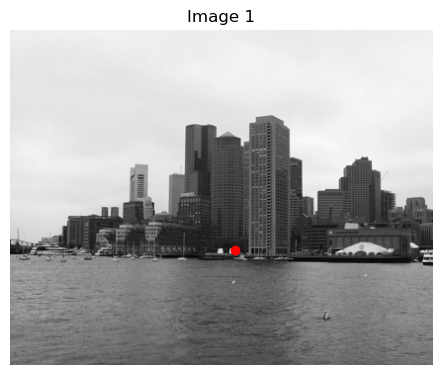

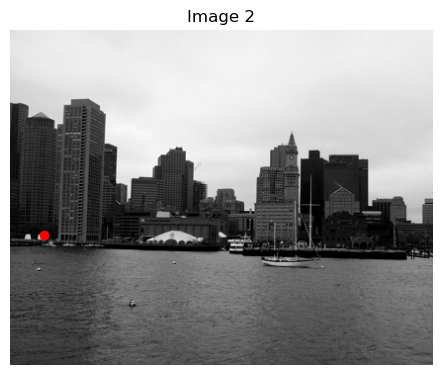

In [25]:
# Given

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_1_resized, cmap='gray')
plt.scatter(Location1[1], Location1[0], color='red')
plt.title("Image 1")
plt.axis('off')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_2_resized, cmap='gray')
plt.scatter(Location2[1], Location2[0], color='red')
plt.title("Image 2")
plt.axis('off')


### Task6: Apply Non-Maximal Suppression (NMS). Follow the instruction.

**TODO** Apply Non-Maximal Suppression (NMS) to find local maxima of the corner response function in small regions. We will call the output `local_max_R1` and `local_max_R2`. 
   * To do so, first define a filter $3\times3$ with center as $0$, you can use `np.ones` for example and replace the center with 0 value. 
   * Then use the function we imported that is called `maximum_filter()` which takes as arguments the image and the filter. You can use `mode='constant'`. This function will replaces each pixel in matrix with the maximum value in its 3×3 neighborhood.
   * Display the new response.

In [26]:
# Define 3x3 filter with center as 0
filter_maxima = np.ones((3, 3))
filter_maxima[1,1] = 0

# Apply maximum filter to compare neighbors
local_max_R1 = maximum_filter(R1, footprint=filter_maxima, mode='constant')
local_max_R2 = maximum_filter(R2, footprint=filter_maxima, mode='constant')
 
 

(-0.5, 427.5, 338.5, -0.5)

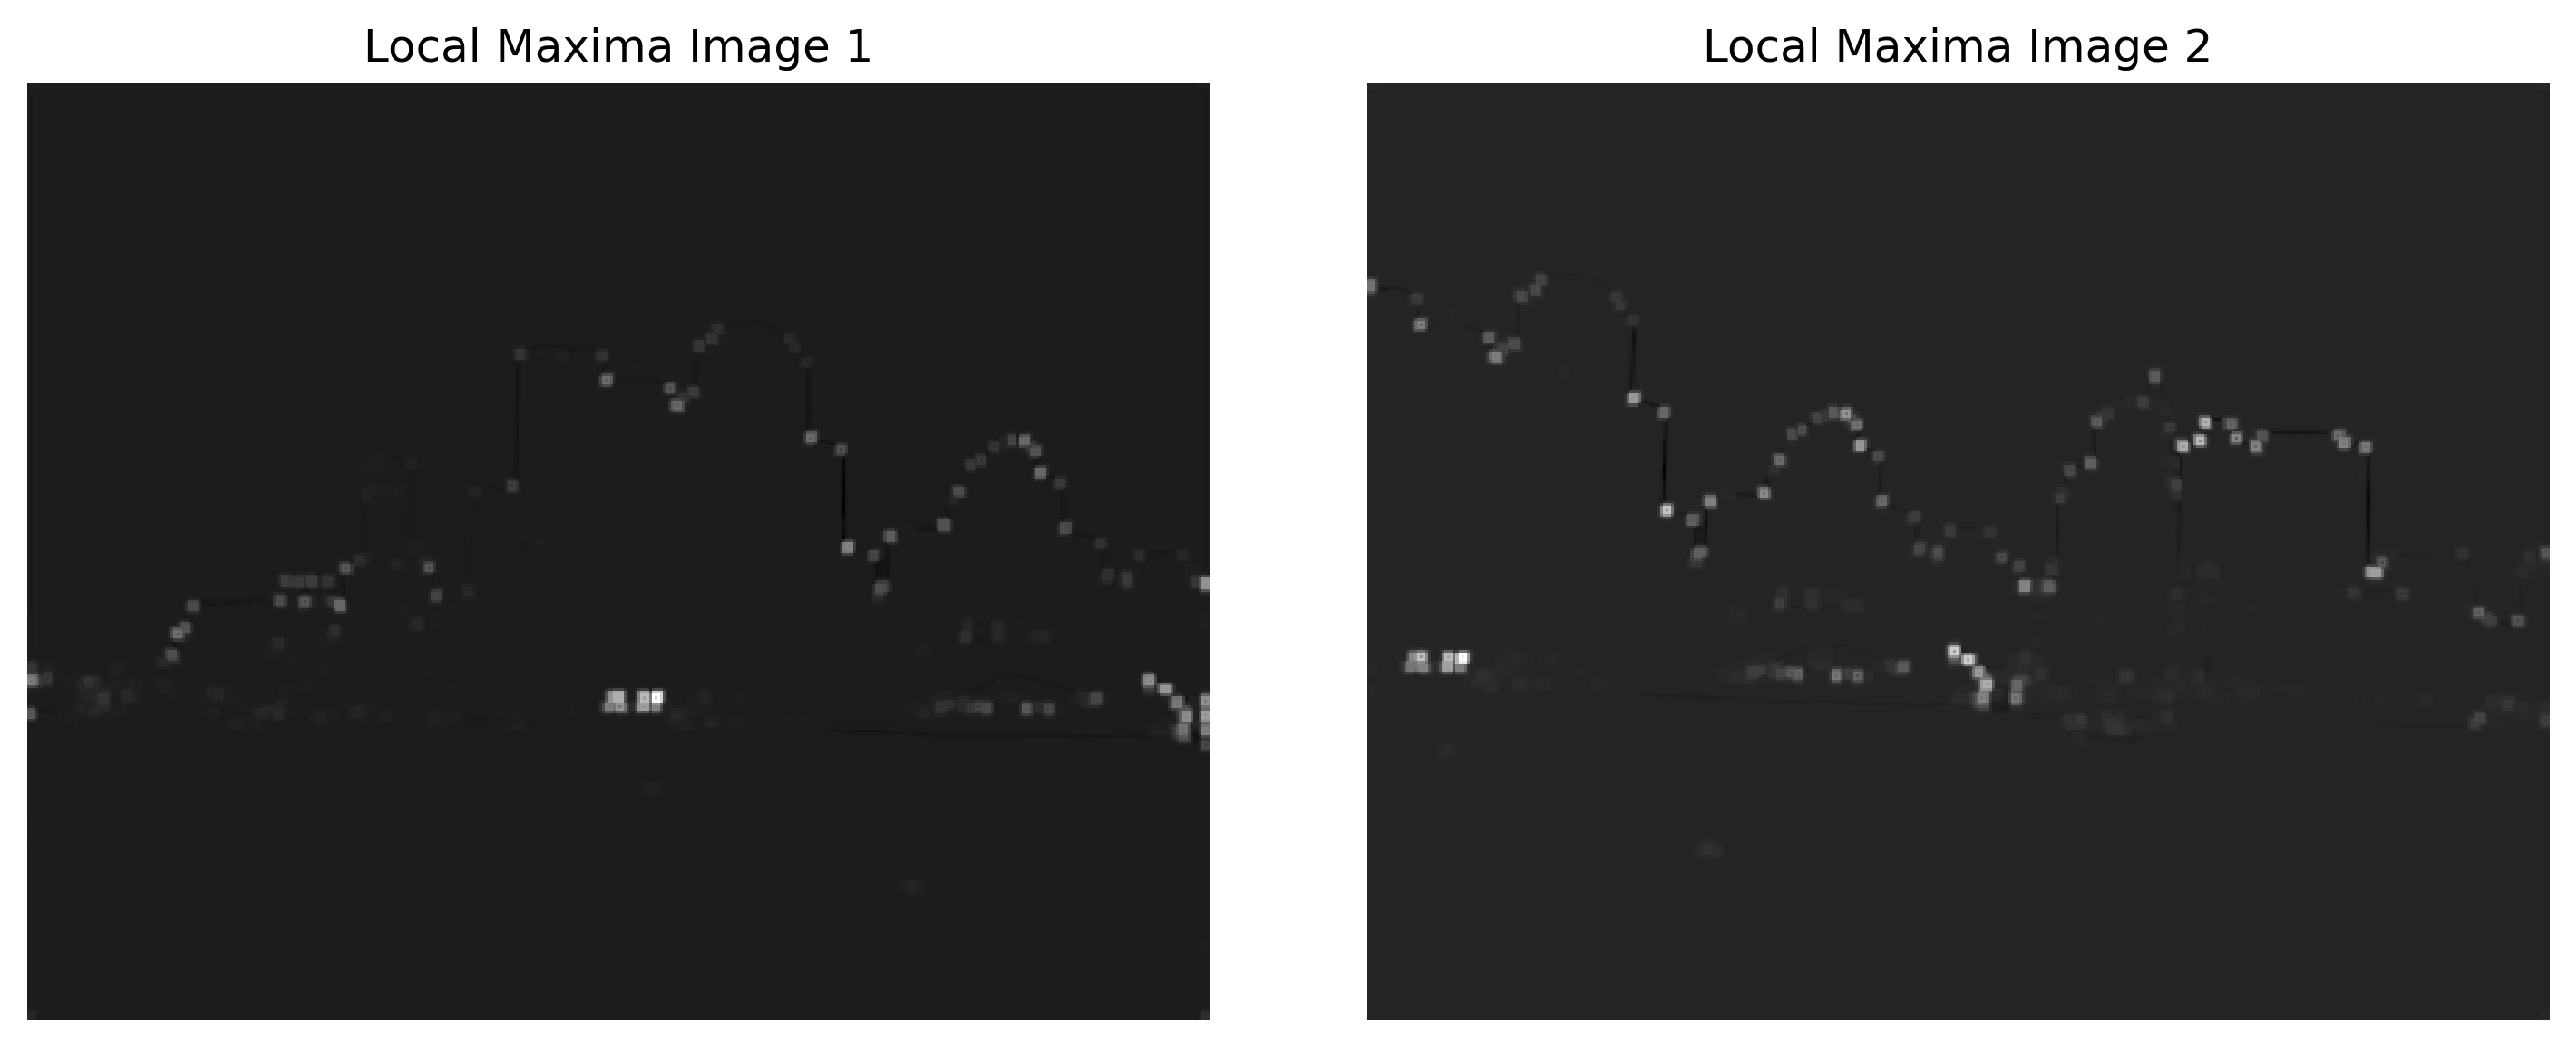

In [27]:
fig, ax = plt.subplots(1, 2,figsize=(10, 10), dpi=300)
 
fig.tight_layout()
ax[0].imshow(local_max_R1, cmap='gray')
ax[0].set_title('Local Maxima Image 1')
ax[0].axis('off')
ax[1].imshow(local_max_R2, cmap='gray')
ax[1].set_title('Local Maxima Image 2')
ax[1].axis('off')
###

Nous retrouvons un résultat cohérent avec ce que nous avons trouvé plus haut: nous discernons nos points "max_corner_values" sur nos images, ainsi que la structure générale de l'objet présent sur l'image, délimité par les coins.

### Task7: Detecting and Thresholding Corners based on the local maximum response we obtained. Follow the instruction.


**TODO**
* Extract the **corner points** from each image** and store them in:
   - `cornerImg1` for **image 1**
   - `cornerImg2` for **image 2**

   - **Such that a pixel** is considered a **corner** if its **Harris response value satisfies**:

   $$
   R > \text{local_max_R}
   $$

   where `local_max_R` is the **local maximum response** we computed earlier.

* Display the detected corner images (`cornerImg1` and `cornerImg2`).
* Analyze and describe what you observe** about the detected corners.
* How does adjusting `local_max_R` via changing the filter np.ones((3,3)) to np.ones((9,9)) impact the number of detected corners? Is it less? More? Would this have impact on the quality of the final declared corners?





In [28]:
# Test if cornerness is larger than neighborhood (faire un plot adapté)


cornerImg1 = (R1 > local_max_R1).astype(int)
cornerImg2 = (R2 > local_max_R2).astype(int)


print("Corner Detected in Image 1:", cornerImg1)
print("Corner Detected in Image 2:", cornerImg2)

Corner Detected in Image 1: [[0 0 1 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
Corner Detected in Image 2: [[0 0 1 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


(-0.5, 427.5, 338.5, -0.5)

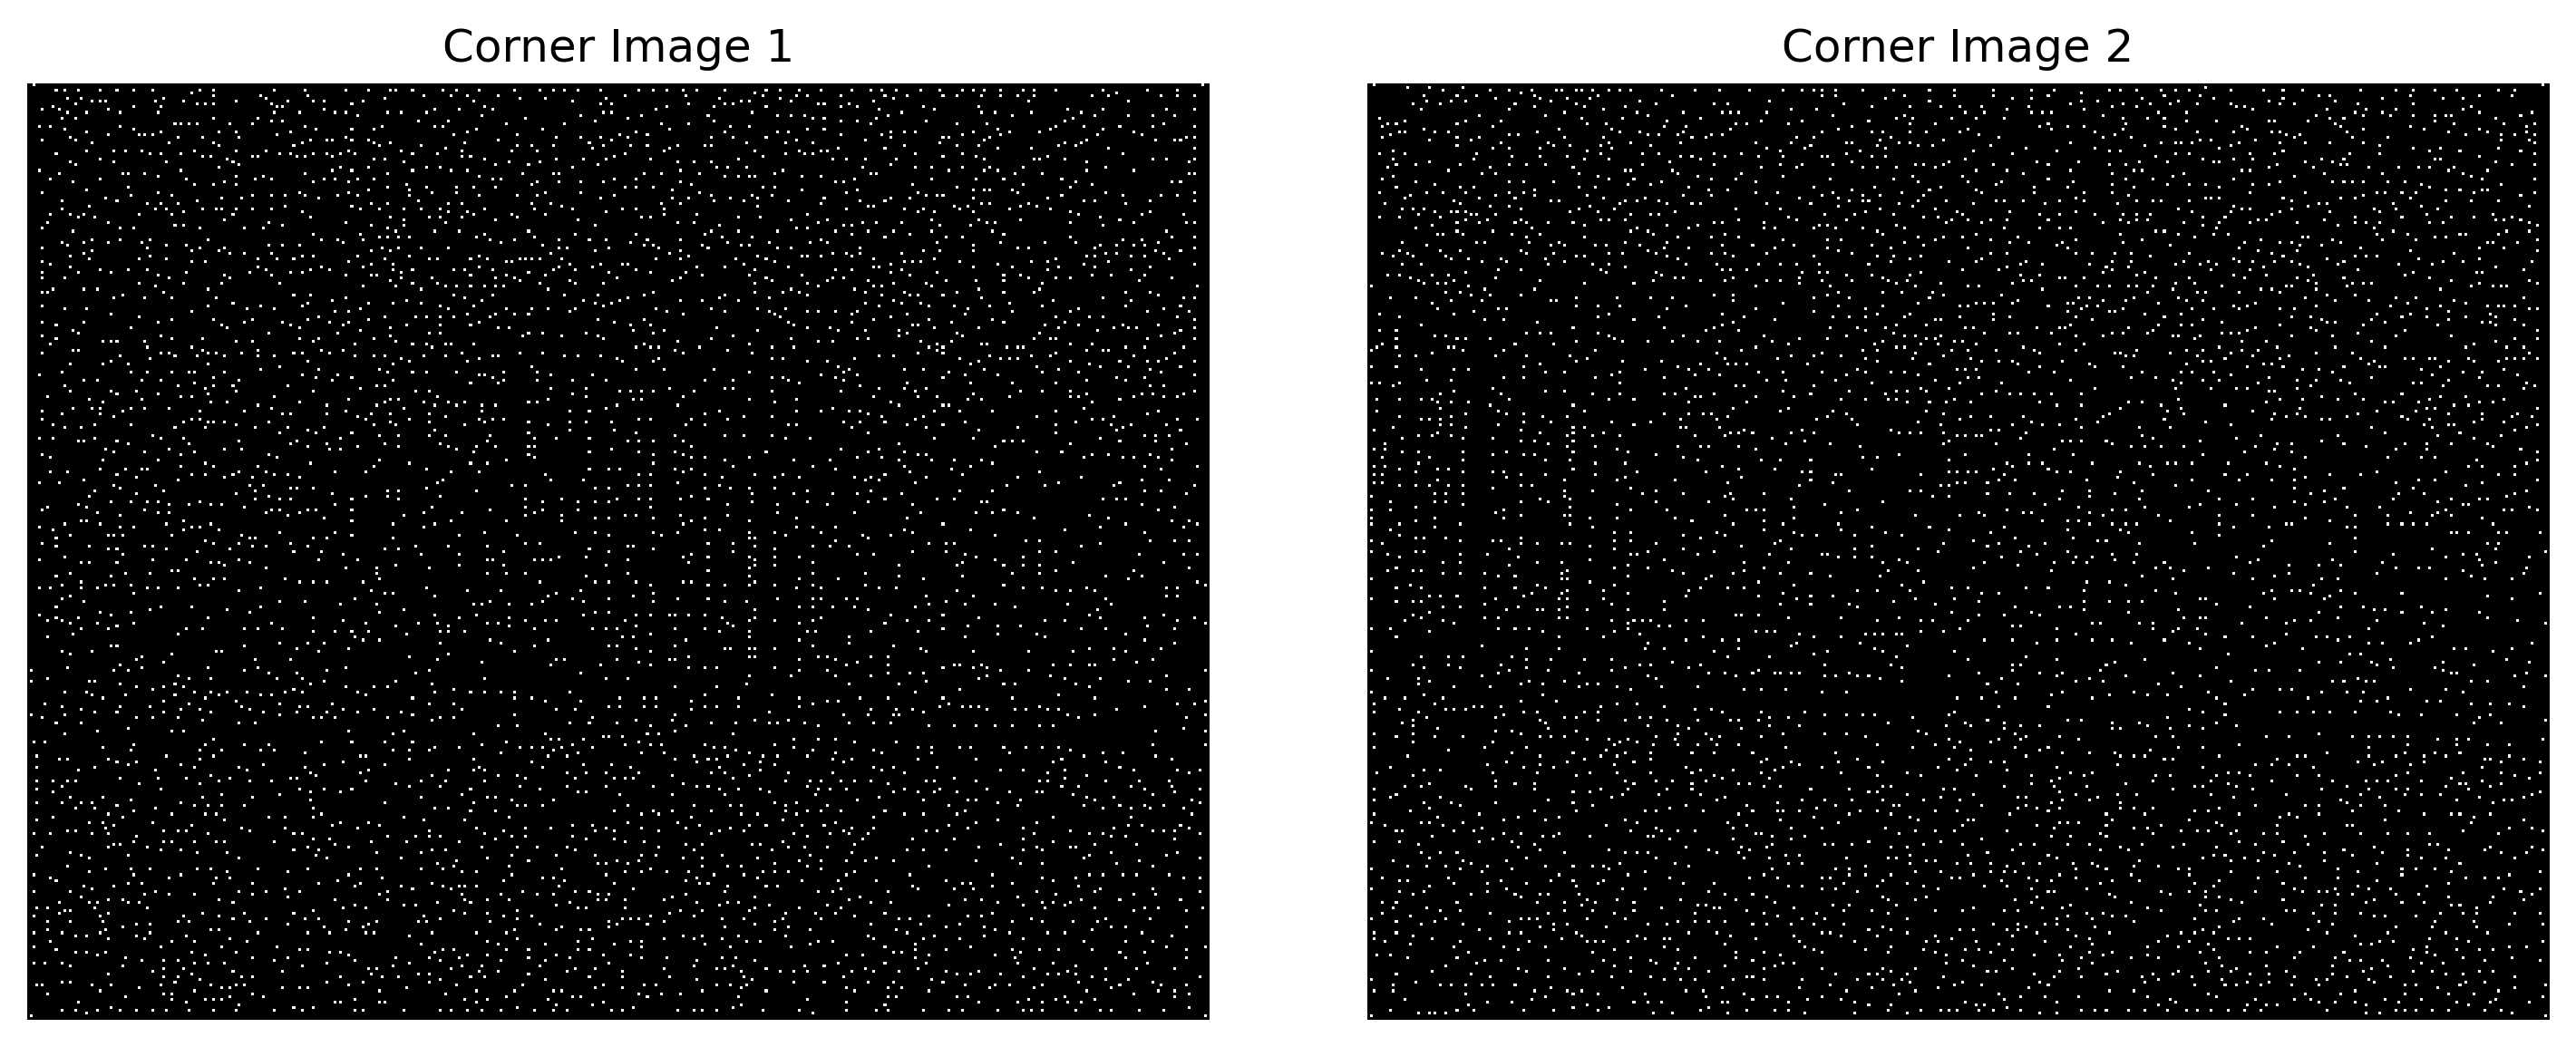

In [29]:
fig, ax = plt.subplots(1, 2,figsize=(10, 10), dpi=300)
 
fig.tight_layout()

ax[0].imshow(cornerImg1, cmap='gray')
ax[0].set_title('Corner Image 1')
ax[0].axis('off')
ax[1].imshow(cornerImg2, cmap='gray')
ax[1].set_title('Corner Image 2')
ax[1].axis('off')
###

Nous remarquons que les légères différences dans le ciel et la mer sont détectés par notre algorithme, ce qui génère énormément de points. Nous allons alors réaliser un processing afin de supprimer ces points. 

### Applying Thresholding to Filter Weak Corners. Follow the instruction.

To filter out weak corners, we apply a thresholding step as follows:

1. **Compute the threshold value**  
   - Multiply the **maximum Harris response value** (`maxCornerValue`) obtained in Task5 by a chosen threshold (`relTh`).  
   - Example: If `relTh = 0.001`, the threshold is computed as:  
     $$
     \text{Threshold} = \text{relTh} \times \text{maxCornerValue}
     $$
   - **TODO** Compute $Threshold1$ and $Threshold2$ for each of the two images and consider `relTh = 0.001`.

2. **Apply the threshold to the detected corners**  
   - **TODO** Retain only the corners with a Harris response greater than this threshold.  
       - This is achieved using the condition:
         $$
         R > \text{Threshold} \times \text{cornerImg}
         $$
       - This ensures that only **strong and meaningful corners** are kept while weaker and noisy detections are discarded.
       
3. **GIVEN** we will superimpose the obtained corners on their original images.        

 
4. To help you assess the quality of the detected corners, we will run the function `feature_matching()`. This function compares each detected corner to the rest and attempts to find potential matches by evaluating the similarity between these features.

    1. **Run the provided code** as it is and observe whether the features are correctly matched.  
    2. **Analyze the results:** Were the matches accurate? Why or why not?  
    3. **Modify the threshold:** Set `relTh = 0.1` in a new experiment, recompute the necessary variables, and rerun `feature_matching()`. Then, reassess the outcomes.  
    4. **Observe the impact of adjusting `relTh`**:  
       - Does it affect the **sensitivity** of corner detection?  
       - How does increasing `relTh` impact the results?  
       - What happens when `relTh` is lowered?  




In [30]:
# Definition of the choosen Threshold
relTh_1=0.015
relTh_2 = 0.17
Threshold1_1 = relTh_1 * maxCornerValue1
Threshold2_1 = relTh_1 * maxCornerValue2
Threshold1_2 = relTh_2 * maxCornerValue1
Threshold2_2 = relTh_2 * maxCornerValue2

cornerImgThresholded1_1 = (R1 > Threshold1_1)*cornerImg1
cornerImgThresholded2_1 = (R2 > Threshold2_1)*cornerImg2
cornerImgThresholded1_2 = (R1 > Threshold1_2)*cornerImg1
cornerImgThresholded2_2 = (R2 > Threshold2_2)*cornerImg2

(-0.5, 427.5, 338.5, -0.5)

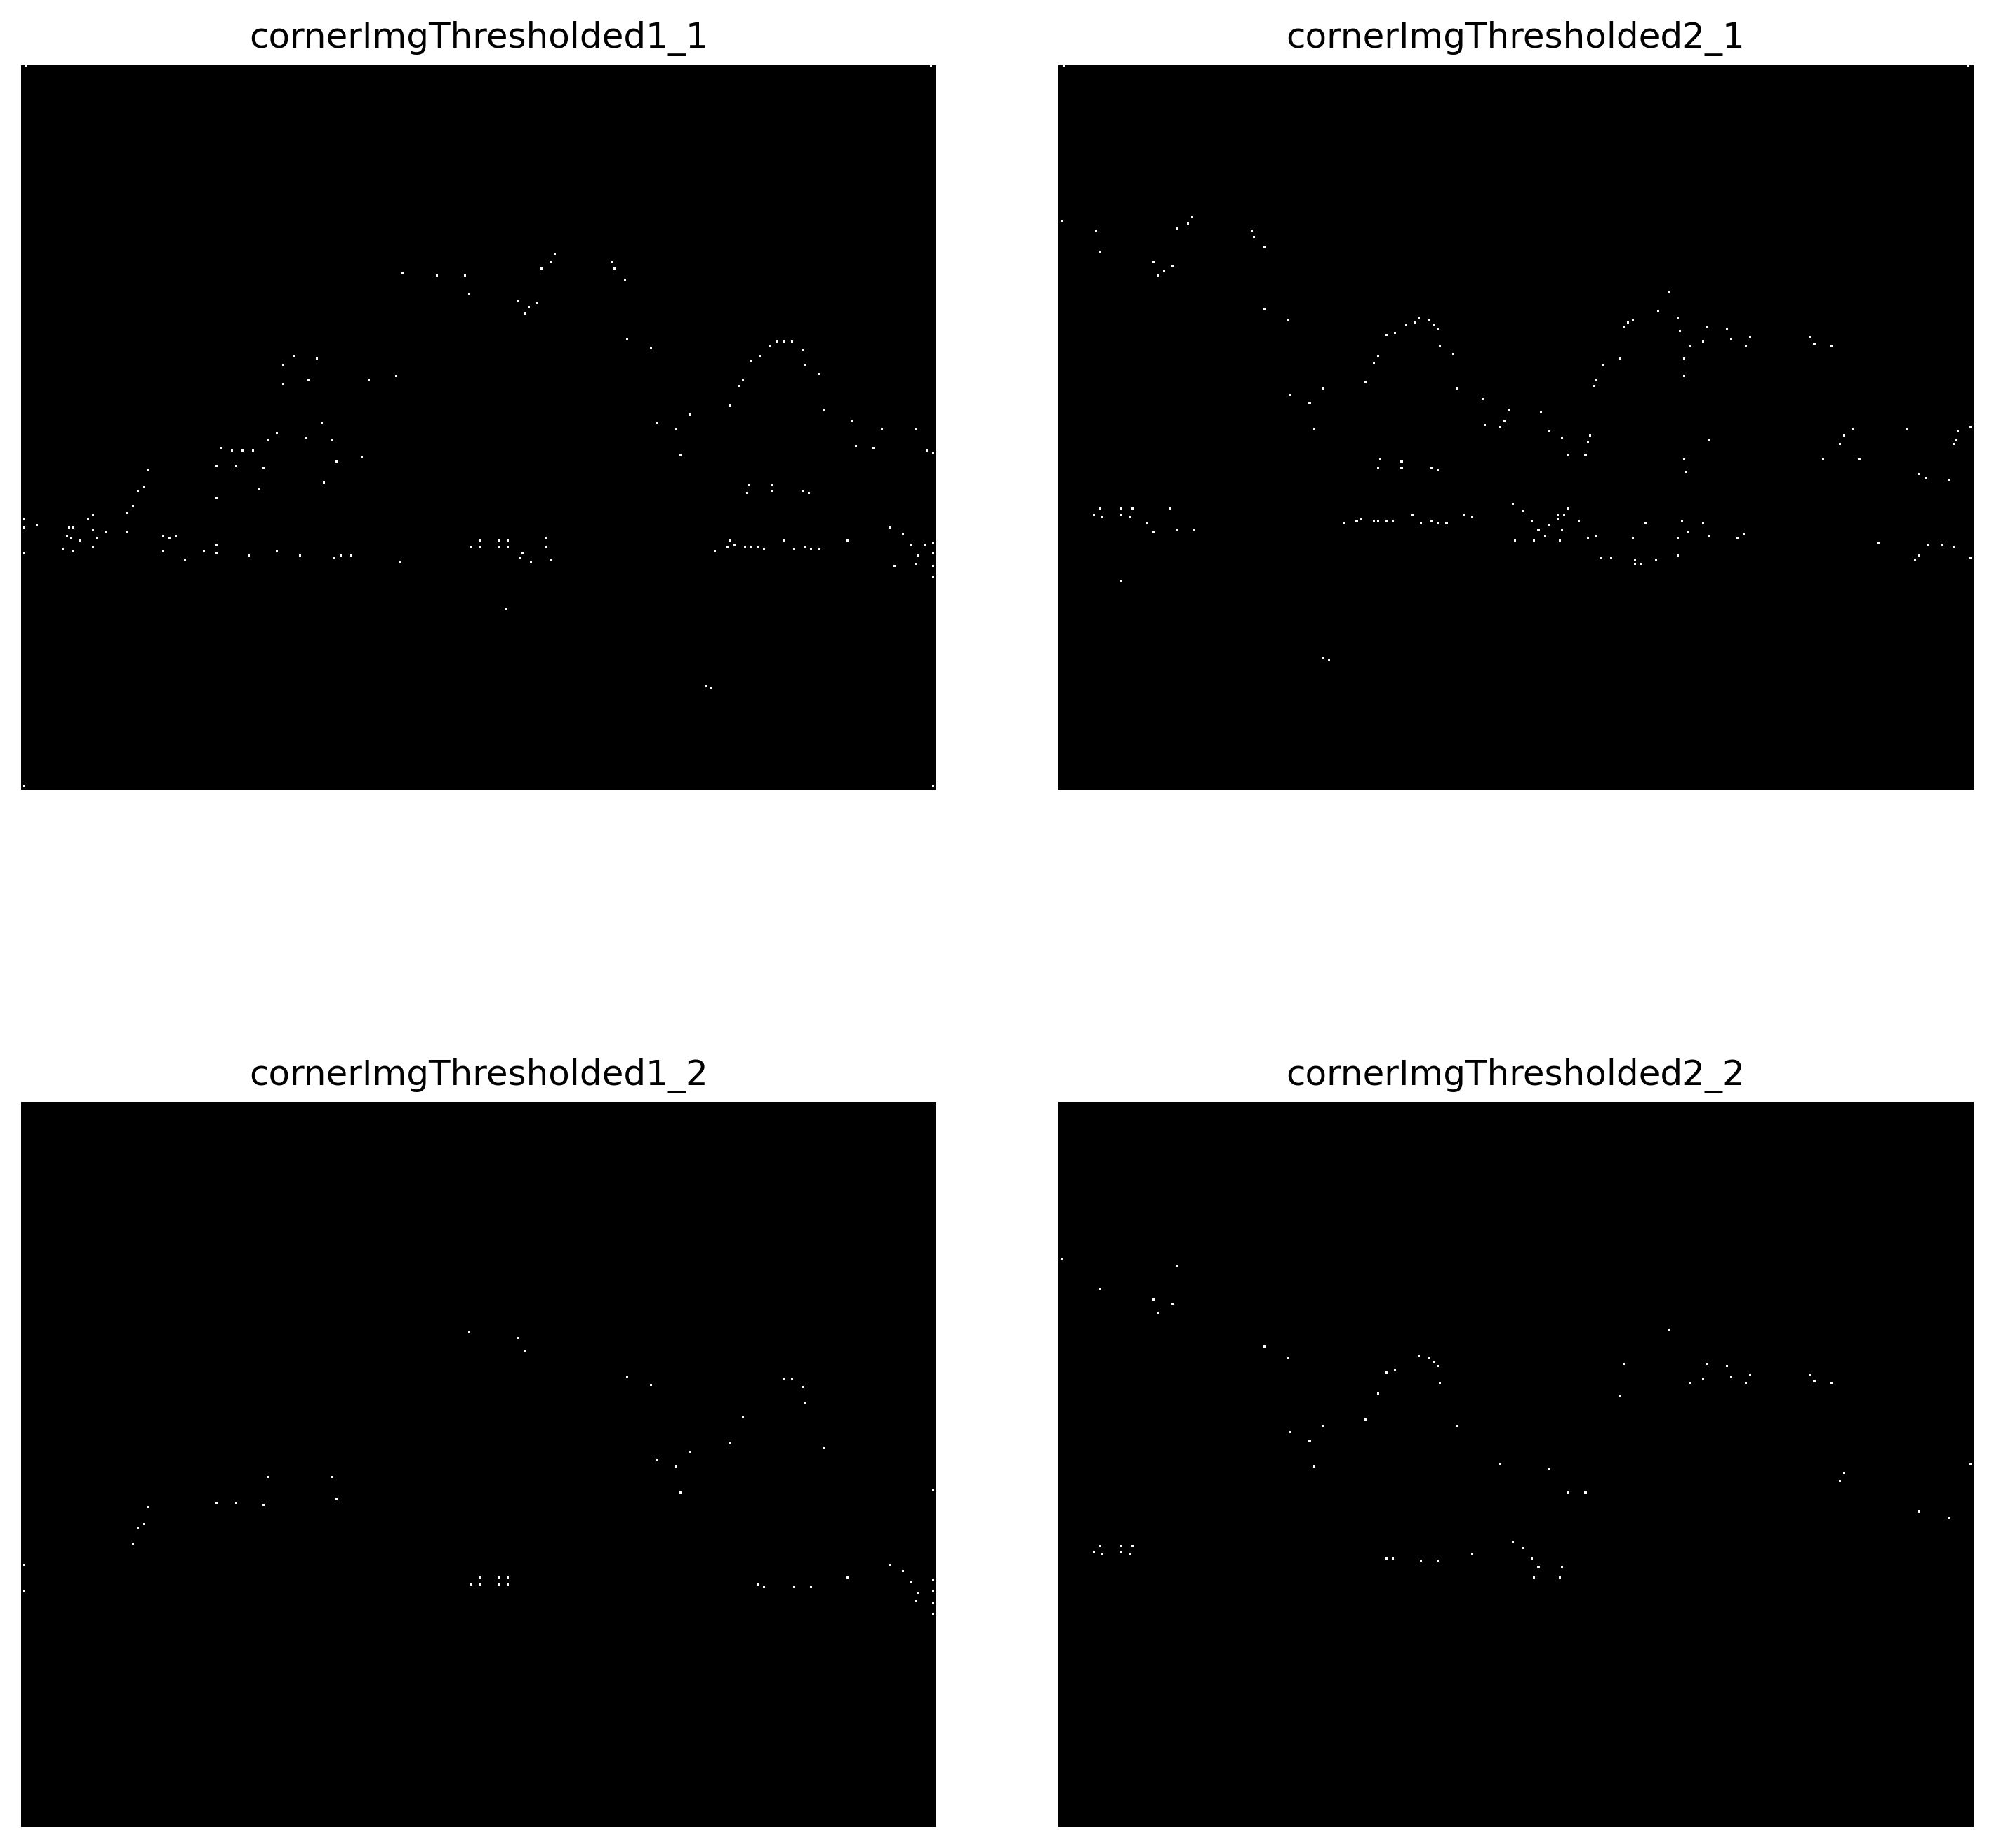

In [31]:
fig, ax = plt.subplots(2, 2,figsize=(10, 10), dpi=300)
 
fig.tight_layout()


ax[0,0].imshow(cornerImgThresholded1_1, cmap='gray')
ax[0,0].set_title('cornerImgThresholded1_1')
ax[0,0].axis('off')

ax[0,1].imshow(cornerImgThresholded2_1, cmap='gray') 
ax[0,1].set_title('cornerImgThresholded2_1')
ax[0,1].axis('off')

ax[1,0].imshow(cornerImgThresholded1_2, cmap='gray')
ax[1,0].set_title('cornerImgThresholded1_2')
ax[1,0].axis('off')

ax[1,1].imshow(cornerImgThresholded2_2, cmap='gray') 
ax[1,1].set_title('cornerImgThresholded2_2')
ax[1,1].axis('off')
 

(-0.5, 427.5, 338.5, -0.5)

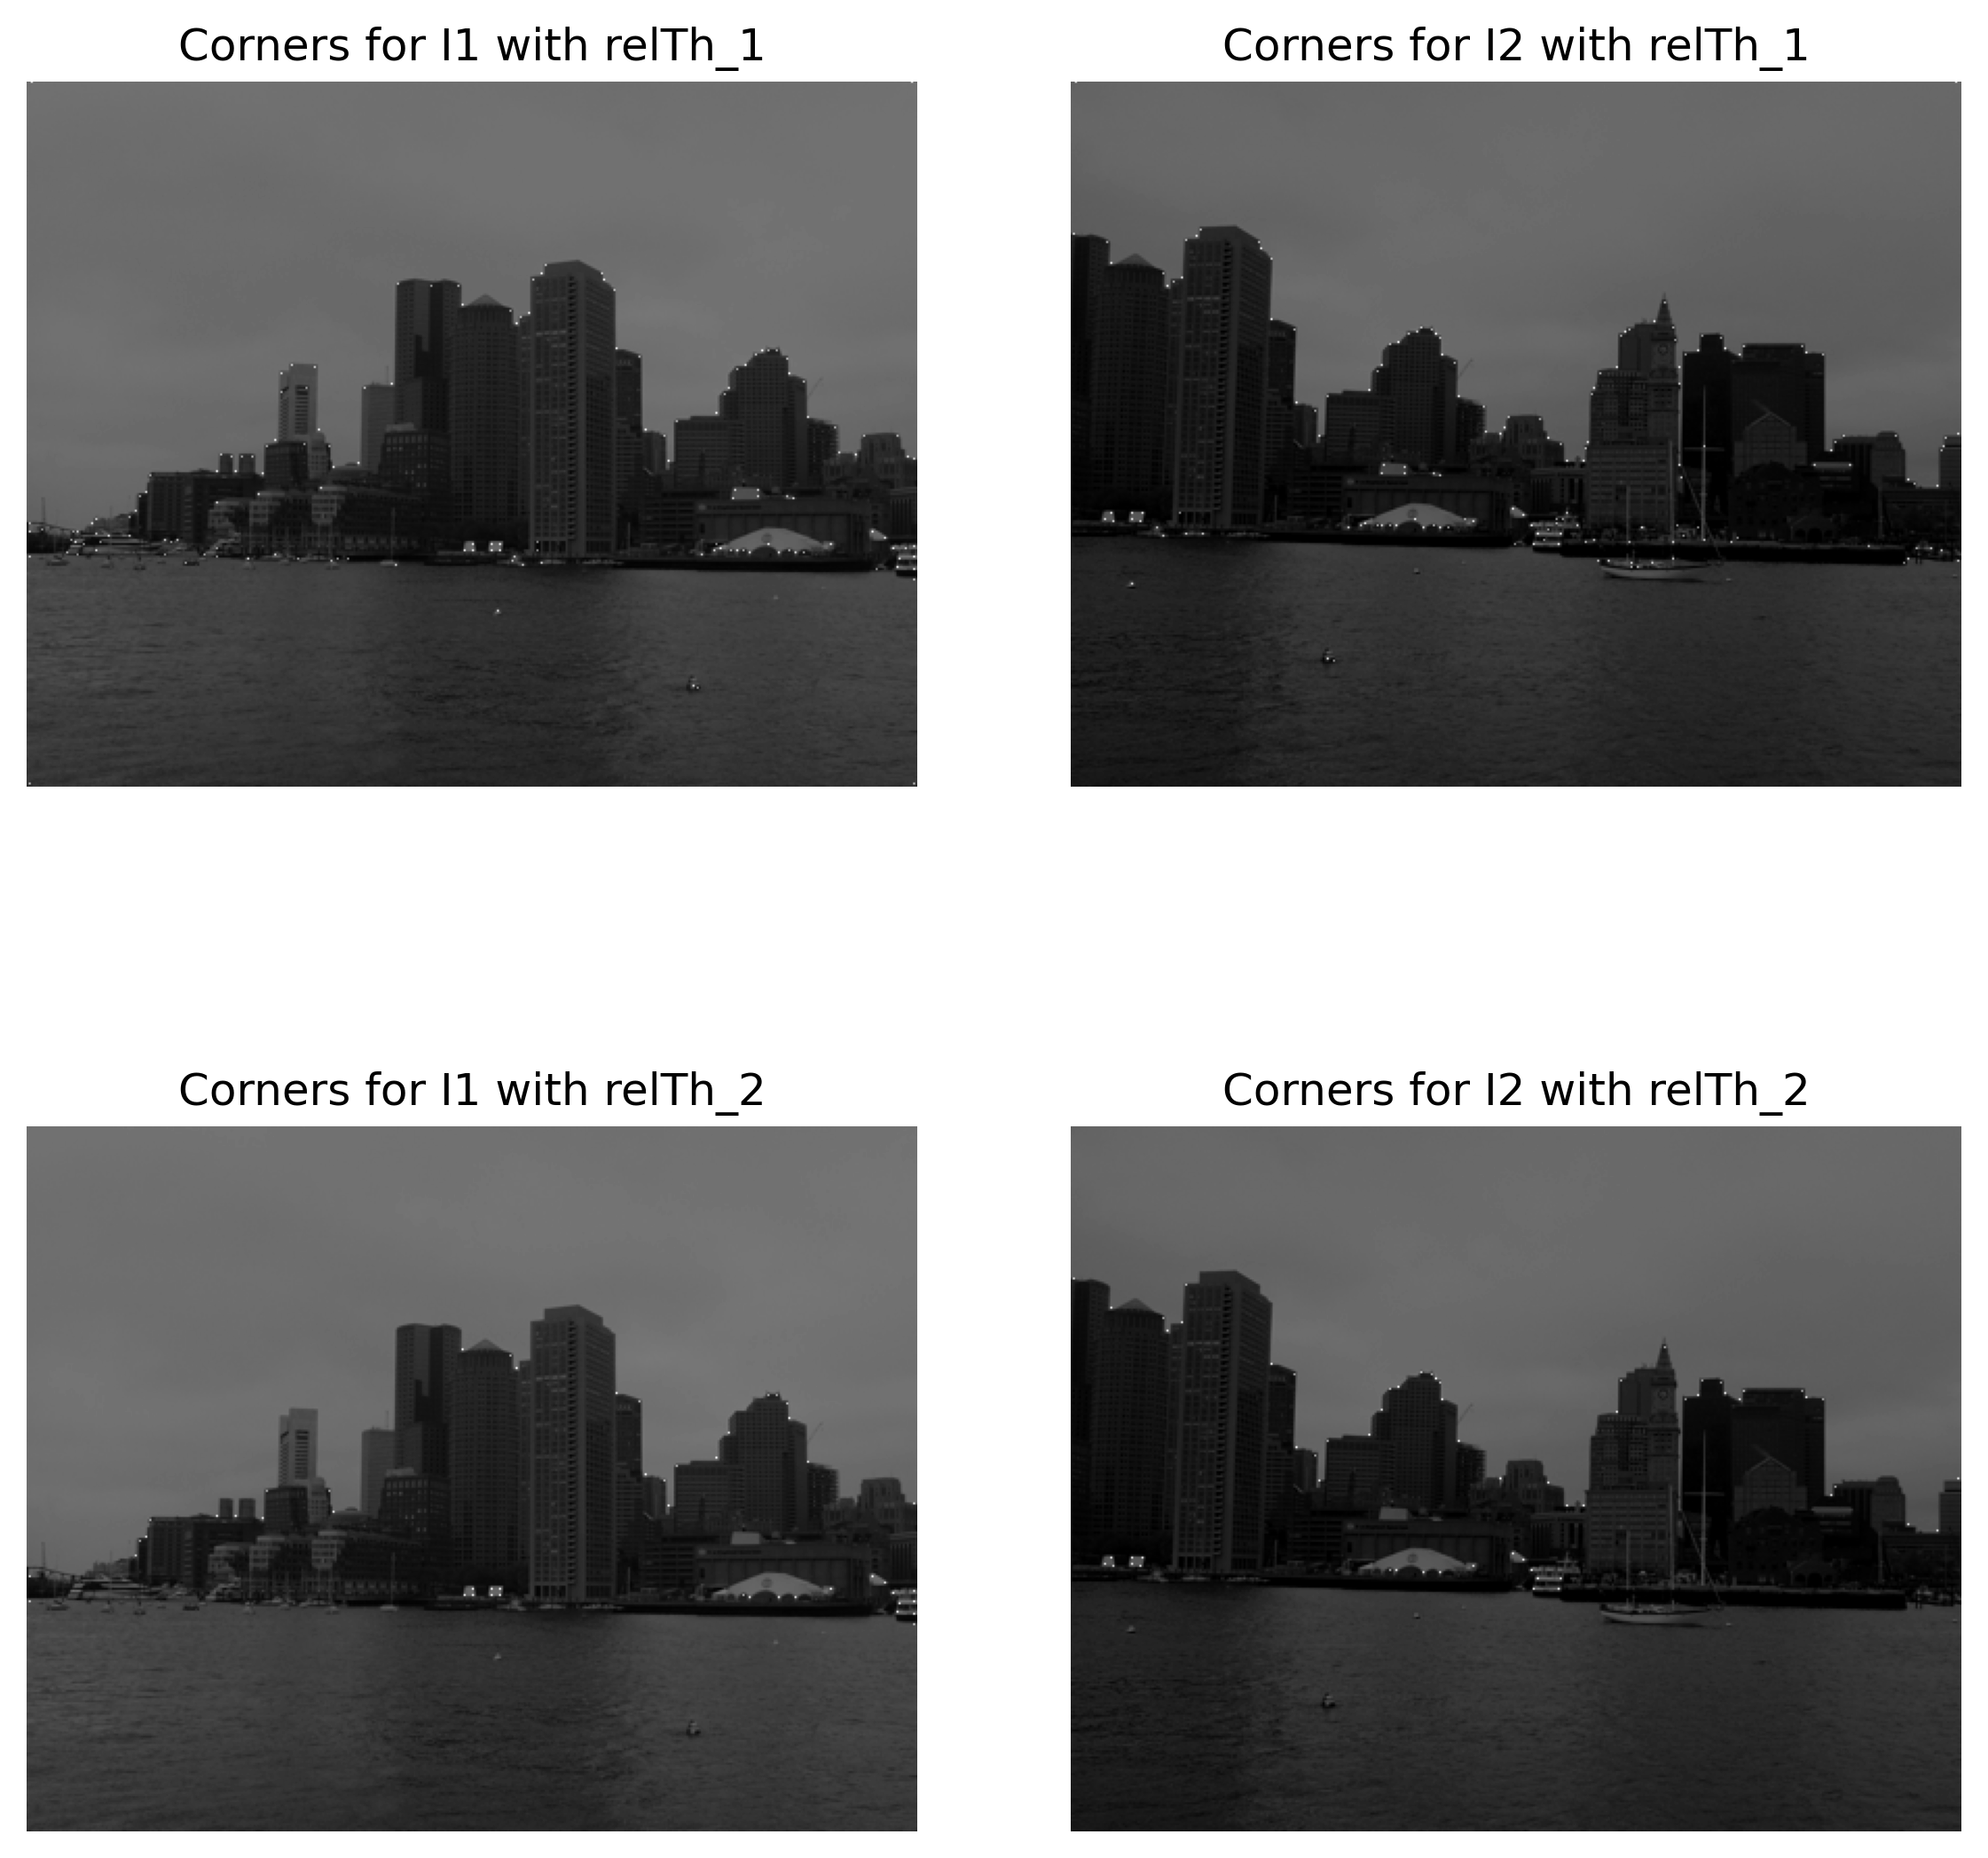

In [32]:
# given
fig, ax = plt.subplots(2, 2,figsize=(8, 8), dpi=300)
 
fig.tight_layout()


ax[0,0].imshow(cornerImgThresholded1_1+image_1_resized, cmap='gray')
ax[0,0].set_title('Corners for I1 with relTh_1')
ax[0,0].axis('off')

ax[0,1].imshow( cornerImgThresholded2_1+image_2_resized, cmap='gray')
ax[0,1].set_title('Corners for I2 with relTh_1')
ax[0,1].axis('off')

ax[1,0].imshow(cornerImgThresholded1_2+image_1_resized, cmap='gray')
ax[1,0].set_title('Corners for I1 with relTh_2')
ax[1,0].axis('off')

ax[1,1].imshow( cornerImgThresholded2_2+image_2_resized, cmap='gray')
ax[1,1].set_title('Corners for I2 with relTh_2')
ax[1,1].axis('off')
 

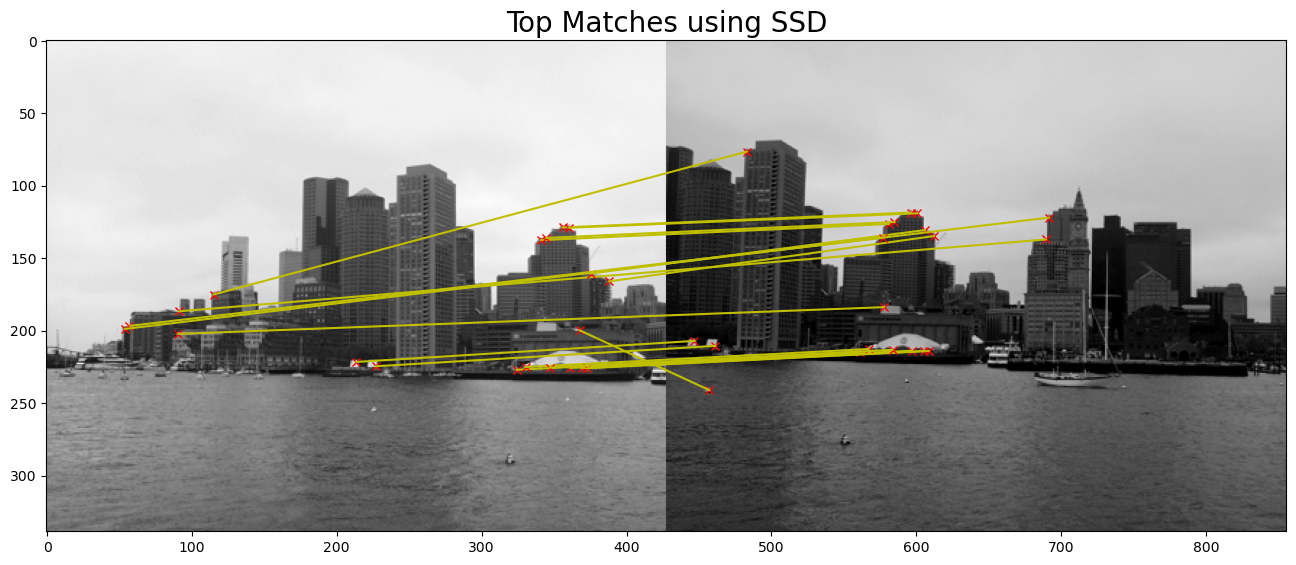

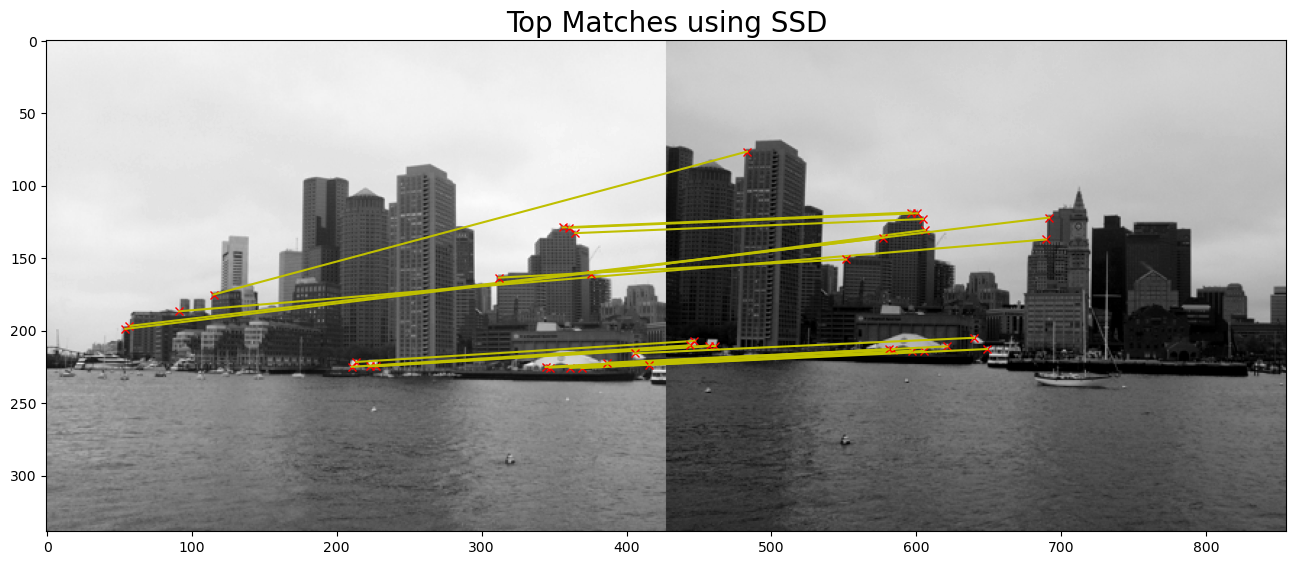

In [33]:
#Given
H_1 = feature_matching(image_1_resized, R1, cornerImgThresholded1_1, image_2_resized, R2, cornerImgThresholded2_1, 20)
H_2 = feature_matching(image_1_resized, R1, cornerImgThresholded1_2, image_2_resized, R2, cornerImgThresholded2_2, 20)



L'impact du paramètre relTh est significatif dans le Harris Corner Detector et le feature matching. Un relTh faible permet de détecter un plus grand nombre de coins, incluant ceux ayant une réponse de Harris modérée. Cela augmente le nombre de points d'appariement possibles, mais accroît le risque de faux appariements, car des coins structurellement différents mais présentant des gradients similaires peuvent être associés. À l'inverse, un relTh élevé restreint la détection aux coins les plus saillants, limitant les erreurs mais réduisant le nombre de matches potentiels.

Sachant que le threshold choisi est aussi fonction du MaxCornerValue, le nombre et la valeur des points retenues vont ainsi dépendre de ces valeurs: une valeur faible de MaxCornerValue va détecter plus de coins et ainsi facilité le "faux appariement" de coins, alors qu'une valeur importante de MaxCornerValue va limiter (peut être un peu trop) le nombre de coins retenues.

L’angle de vue entre les deux images influe directement sur la qualité du matching. Les réponses de Harris dépendent des variations locales d'intensité, et un changement d’angle modifie ces gradients, générant des appariements erronés. Par exemple, l’angle du premier bâtiment à gauche dans l’image 1 est apparié à un bâtiment au-dessus du voilier dans l’image 2 (pour relTh = 0.015) car leurs gradients et réponses de Harris sont les plus proches, malgré le fait qu'il n'y ai pas réellement de correspondance. Un autre facteur d’erreur est la périodicité des formes dans l'image. Lorsque des motifs répétitifs (comme des fenêtres ou des toitures rectangulaires) se répètent dans les deux images, plusieurs coins présentent des descripteurs similaires. Cela induit des faux appariements puisque les critères utilisés pour comparer les coins, souvent basés sur des descripteurs locaux, peinent à différencier les structures identiques mais spatialement distinctes.

# Problem 2: Scale-Space Blob Detection

In this Problem, we aim to detect blobs (circular regions of interest) at multiple scales in an image. This method helps us identify key structures regardless of their size, making it useful for scale-invariant feature detection.

To achieve this, we use the Laplacian of Gaussian (LoG) filter, applied across multiple scales, to find regions where the response is locally maximized.

The steps are:

* Applying Gaussian smoothing at different scales.
* Computing the Laplacian of Gaussian (LoG) to highlight blobs.
* Building a scale-space representation by stacking LoG responses at different scales.
* Detecting local maxima across both spatial (x, y) and scale (σ) dimensions to determine blob locations and sizes.
* Drawing circles around detected blobs to visualize results.



In [34]:
# Modification on the previous function to include the 2nd derivatives.
def Gaussian_2D_Laplacians(sigma, N=None):
    """
    Compute a 2D Gaussian filter kernel and its derivatives (1st and 2nd order).
    
    Parameters:
    - sigma (float): Standard deviation of the Gaussian distribution.
    - N (int, optional): Radius (half-size) of the filter. If None, uses ceil(3*sigma).
    
    Returns:
    - G   (ndarray): 2D Gaussian kernel of size (2*radius+1) x (2*radius+1).
    - Gx  (ndarray): Partial derivative of G w.r.t. x (horizontal direction).
    - Gy  (ndarray): Partial derivative of G w.r.t. y (vertical direction).
    - Gxx (ndarray): Second-order partial derivative of G w.r.t. x (Laplacian of Gaussian).
    - Gyy (ndarray): Second-order partial derivative of G w.r.t. y.
    - Gxy (ndarray): Mixed second-order partial derivative (cross term).
    """
    # Determine the radius of the kernel
    radius = int(np.ceil(3 * sigma)) if N is None else N
    
    # Create a coordinate grid from -radius to +radius
    x = np.arange(-radius, radius + 1, dtype=np.float64)
    X, Y = np.meshgrid(x, x)
    
    # Compute the Gaussian function
    exponent = -0.5 * (X**2 + Y**2) / (sigma**2)
    G = np.exp(exponent) / (2 * np.pi * sigma**2)
    
    # Normalize the kernel to sum to 1
    G /= G.sum()
    
    # Compute first-order derivatives
    Gx = -(X / sigma**2) * G
    Gy = -(Y / sigma**2) * G
    
    # Compute second-order derivatives (Laplacian of Gaussian components)
    Gxx = ((X**2 / sigma**4) - (1 / sigma**2)) * G
    Gyy = ((Y**2 / sigma**4) - (1 / sigma**2)) * G
    Gxy = (X * Y / sigma**4) * G
    
    return G, Gx, Gy, Gxx, Gyy, Gxy


**TODO** 1. Load the image `boat.png` and normalise it, otherwise we get only big blobs, we lose the small blobs, same effect as Laplacian Response Decay Problem we seen in the class.

In [35]:
img = imread("boat.png")
img = img / 255.0

**TODO** 2. Display the image.

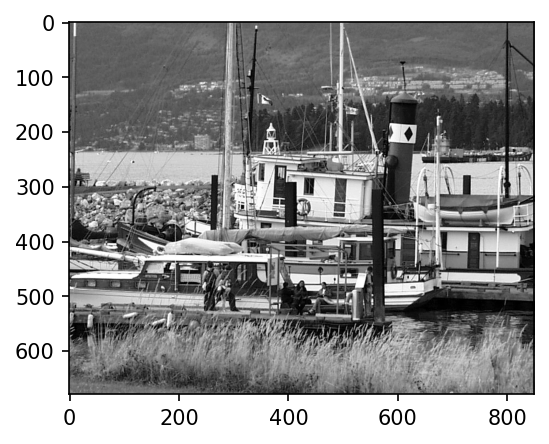

In [36]:
plt.figure(figsize=(4, 4), dpi=150)
plt.imshow(img, cmap='gray')



3. **GIVEN** we will allocate some parameters and variables for storage.

In [37]:
sigma0 = 0.5  # The first sigma to start with
k = 1.19         
Nscales = 20 # Number of scales in scalespace 

In [38]:
# Allocate memory for the scale space, sigmas and filtered images
scalespace = np.zeros((img.shape[0], img.shape[1], Nscales))
sigmas = np.zeros(Nscales)
tmpxx = np.zeros(img.shape)
tmpyy = np.zeros(img.shape)
    

4. **TODO** Print the shape of the matrix `scalespace`. How many channels we have defined and what each channel will corresponds for?

In [39]:
print(scalespace.shape)

(680, 850, 20)


Les trois channels définie correspondent respectivement à la taille verticale de l'image, la taille horizontale de l'image et le nombre d'échelle d'espace

In blob detection, the **Laplacian of Gaussian (LoG)** response at each scale \( i \) is given by:

$$\mathcal{L}(x, y, \sigma) = \sigma^2 \left( \frac{\partial^2 G}{\partial x^2} * I + \frac{\partial^2 G}{\partial y^2} * I \right)$$

where:
- $G(x, y, \sigma)$ is the **Gaussian filter** with standard deviation \( \sigma \).
- $I(x, y)$ is the **input image**.
- $\nabla^2 G = \frac{\partial^2 G}{\partial x^2} + \frac{\partial^2 G}{\partial y^2}$ is the **Laplacian of Gaussian (LoG)**.
- \( * \) represents **convolution**.
- The factor $\sigma^2$ is used to ensure **scale normalization**, making responses comparable across different scales. It what we have seen in the class.
 

5. **TODO** Next we will create a scalespace based on Nscales and then we gradually change sigmas[i] values. Follow the instruction in the code and fill the part with TODO


In [40]:
# We will create a scalespace based on Nscales and then we gradually change  sigmas[i]  values.
for i in range(Nscales):
    
    # Define sigmas for each scale:
    sigmas[i] = (k ** i) * sigma0
    
    #TODO: Define a Gaussian Filter g using the function `Gaussian_2D_2()` and get its Laplacians gxx and gyy (2nd Derivatives)
    g,_,_,gxx,gyy,_, = Gaussian_2D_Laplacians(sigmas[i])

    #TODO: Convolve the image with gxx and store it in tmpxx which will corresponds to \frac{\partial^2 G}{\partial x^2}       
    tmpxx = convolve(img, gxx, mode='constant')   
    
    #TODO: Convolve the image with gyy and store it in tmpyy which will corresponds to \frac{\partial^2 G}{\partial y^2}     
    tmpyy = convolve(img, gyy, mode='constant')   
    
    #TODO: Now compute \mathcal{L}(x, y, \sigma) for each scale \sigma, that is: 
    # for each scale scalespace[:,:,i] you must add tmpxx + tmpyy and then multiply by sigmas[i]**2.
    scalespace[:,:,i] = (tmpxx + tmpyy) * sigmas[i]**2


Augmenter le nombre d'échelle influe énormément sur le temps de calculs, le temps de calcul étant proportionnel à Nscales (j'ai pour ma part des problèmes pour augmenter Nscales, ça crash au delà de 20)

6. **TODO** For each `scalespace[:,:,i]` we will apply Non-Maximum Suppression and store the values in `localmaxima[:,:,i]`. Follow the instruction.
 

In [41]:
# Next, we will select local maxima, where each maxima defines a circular region.

#TODO: Allocate memory for the local maxima images same as the number of scalespace and initialize it with zeros.
localmaxima = np.zeros(scalespace.shape)

# #TODO:  Similar to harris detector,define a filter shape for calculating the local maxima that will be used in
# Non Maximum Suppresion
footprint = np.ones((3,3))
footprint[1,1] = 0

# Perform local maxima detection in the scale-space representation:
for i in range(Nscales):
    
    #TODO: 
    # Calculate local maxima using the function maximum_filter() for scalespace[:,:,i] 
    # using the filter footprint. 
    maxi = maximum_filter(scalespace[:,:,i], footprint=footprint, mode='constant')
    
    #GIVEN:
    # Checks if each pixel's LoG response stored in scalespace[:,:,i] is greater than all its neighbors.
        # If True, the pixel is a local maximum and marked as 1 (True).
        #If False, it's not a local maximum and remains 0 (False).
    localmaxima[:,:,i] = scalespace[:,:,i] > maxi       
 

**The rest is GIVEN:** 

* Next we will selects the final blob keypoints by refining the previously detected local maxima in the scale-space representation. We will ensures that only points that are maxima across both spatial (x, y) and scale (σ) dimensions are kept.
    
* Then, using the function `blobs_points()` we will plot the keypoints and their domain of features, circles.

In [42]:
blobs_list = []  # Store detected blobs efficiently

for i in range(1, Nscales - 1):
    # Extract the current, previous, and next scales using slicing
    scaleA, scaleB, scaleC = scalespace[:, :, i - 1], scalespace[:, :, i], scalespace[:, :, i + 1]

    # Find local maxima indices
    ri, ci = np.nonzero(localmaxima[:, :, i])

    # Select only the maxima that are also maxima across scales
    idmax = np.where((scaleA[ri, ci] < scaleB[ri, ci]) & (scaleC[ri, ci] < scaleB[ri, ci]))[0]
    rlmax, clmax = ri[idmax], ci[idmax]

    # Ensure we have detected maxima before storing them
    if len(rlmax) > 0:
        radius_values = np.full_like(rlmax, np.sqrt(2) * sigmas[i], dtype=np.float64)  # Ensure correct size
        response_values = scaleB[rlmax, clmax]  # Keep the response values

        # Append results as a correctly shaped array
        blobs_list.append(np.column_stack((clmax, rlmax, radius_values, response_values)))

# Convert list to NumPy array (handling empty case)
blobs = np.vstack(blobs_list) if blobs_list else np.empty((0, 4))


In [43]:
"""
blobs.shape:
1st Dimension: is the number of blobs generated
2d Dimension: represents 4 channels:
     Channel 1 represents the x-coordinates
     Channel 2 represents the y-coordinates
     Channel 3 represents the blob  radius of the circle (r=sqrt(2)*sigma)
     Channel 4 represents the response of the Laplacian of Gaussian filter.
    
"""
print(blobs.shape)

(52191, 4)


In [44]:
from matplotlib.patches import Ellipse

# Function to draw ellipses
def draw_ellipses(ax, blobs, color='b', alpha=0.6):
    """Draw detected blobs as ellipses on the given axis."""
    for x, y, r, _ in blobs:
        ellipse = Ellipse(
            xy=(x, y),  # Center
            width=6*np.sqrt(2)*r,  # Width (major axis)
            height=4*np.sqrt(2)*r,  # Height (minor axis)
            angle=np.random.uniform(0, 180),  # Randomized rotation for demonstration
            edgecolor=color,
            facecolor='none',
            linewidth=1.5,
            alpha=alpha
        )
        ax.add_patch(ellipse)


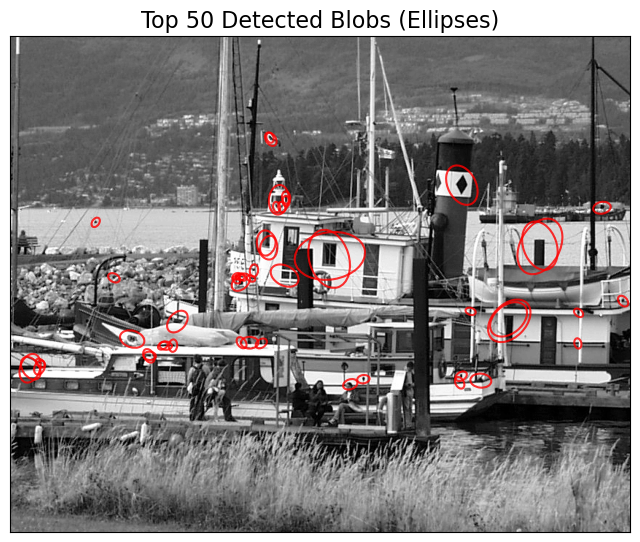

In [45]:
# Sort blobs by response and select top N
N = 50  # Number of top detections to visualize
blobs_sorted = blobs[np.argsort(blobs[:, 3])[::-1]]  # Sort in descending order
blobs_top = blobs_sorted[:min(N, blobs_sorted.shape[0]), :]  # Select top N

# Plot the detected blobs on the image
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title(f"Top {N} Detected Blobs (Ellipses)", fontsize=16)
ax.imshow(img, cmap='gray')  # Show the image
draw_ellipses(ax, blobs_top, color='red', alpha=0.8)  # Draw ellipses

ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks
plt.show()


**TODO: ANALYSIS**
    * The provided image displays detected features as red ellipses overlaid on a grayscale image. These ellipses correspond to blob detections at different scales and locations using the Laplacian of Gaussian (LoG) method.

    1. Are the ellipses concentrated in certain areas?
    2. Does some blobs seem redundant?
    3. Why do some blobs appear larger or smaller than others? What does their size represent?
    4. Do the detected blobs align with significant image structures, such as corners, edges, or textured regions?
    5. If you increase the number of scales, what would happen to the distribution of detected blobs?

Nous voyons que les principaux blop détectés sont sur le bateau, où de nombreux détails avec une intensité lumineuse distincte apparaissent. Les zones plates (l'eau calme ainsi que les broussailles en premir plan) n'ont aucuns blop car l'intensité des pixels varie trop peu et donc la valeur du LoG n'est pas significative. Certains blops ont l'air de se superposer: il représente seulement les valeurs les plus fortes de nos LoG, et ce sont généralement des carrés, où les coins sont détectés indépendamment car ayant une intensité maximale différente, à une échelle différente. La taille des blop correspond au radius_values détecté par notre algorithme, représentant l'échelle du filtre utilisé pour détecter l'objet: plus le blop est gros, plus l'objet détecté est important. Tous les blops les plus significants représente convenablement la structure générale de l'image, détectant les coins, les bordures, etc... 

L'augmentation de Nscales va augmenter le nombre de calculs, mais augmenter la précision, cela peut cependant augmenter le nombre de chevauchement de détection, les valeurs étant de plus en plus proches, au plus les palliers sont proches.

* **Your Feedback (Optional but highly recommended for improving the BE session)**

  1. Was the session too long or too short?
  2. Did you find it easy or difficult?
  3. Was it engaging or uninteresting?
  4. Did you feel adequately guided throughout the session?
  5. What aspects could be improved?"

La longueur est convennable, et nécessaire à la compréhension des méthodes, leur implémentation, ainsi que de voir une application. Le BE est proprement guidés, aucunes étapes ne sont insurmontable, même sans appeler d'enseignant. L'appuie sur le poly du cours est primordial, mais toutes les informations nécessaires sont dessus. 